# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        # cv2.imshow('img',img)
        # cv2.waitKey(500)

cv2.destroyAllWindows()


## Define undistortion function

In [2]:
def undistort(img):
    img_size = (img.shape[1], img.shape[0])

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    return cv2.undistort(img, mtx, dist, None, mtx)


## Test undistortion on a chessboard image

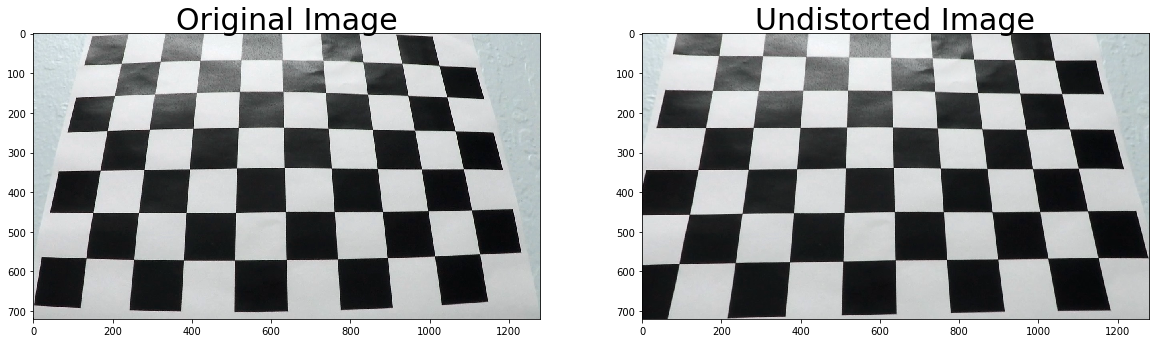

In [3]:
chess_img = cv2.imread('camera_cal/calibration3.jpg')
chess_dst = undistort(chess_img)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(chess_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(chess_dst)
ax2.set_title('Undistorted Image', fontsize=30)


## Test undistortion on a road image

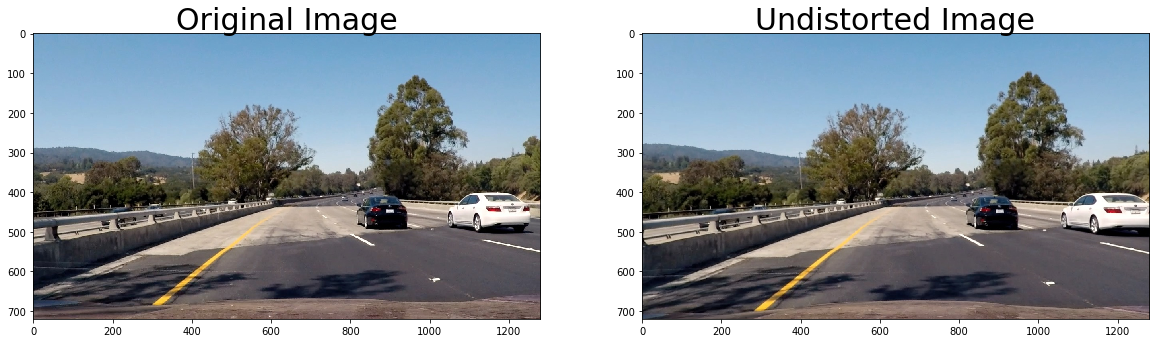

In [4]:
road_img = cv2.imread('test_images/test4.jpg')
road_dst = undistort(road_img)
road_dst = cv2.cvtColor(road_dst, cv2.COLOR_BGR2RGB)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
road_img = cv2.cvtColor(road_img, cv2.COLOR_BGR2RGB)
ax1.imshow(road_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(road_dst)
ax2.set_title('Undistorted Image', fontsize=30)


## Use color transforms, gradients, etc., to create a thresholded binary image

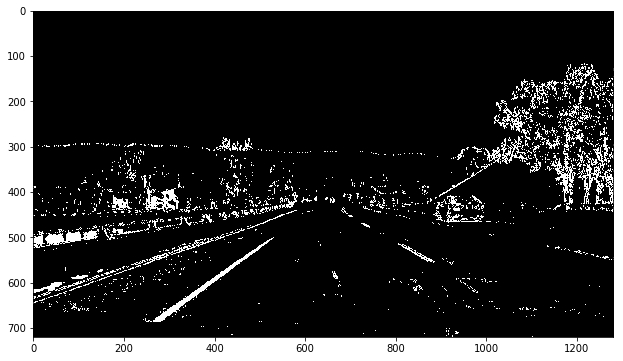

In [5]:
# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    # 2) Apply a threshold to the S channel
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

# Define a function that thresholds the gradients of the image
def gradient(img, sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    l_channel = hls[:,:,1]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    return sxbinary

# Define a function that combines the thresholds
def combined_thersholds(img):
    # Stack each channel
    s_binary = hls_select(img, thresh=(140, 255))
    sxbinary = gradient(img)
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary
    
frame_number = 581
road_img = cv2.imread('video_frames/'+str(frame_number)+'.jpg')
threshold_img = combined_thersholds(road_img)

plt.figure(figsize = (100,6))
plt.imshow(threshold_img, cmap='gray', interpolation='nearest')


## Apply a perspective transform to rectify binary image ("birds-eye view")

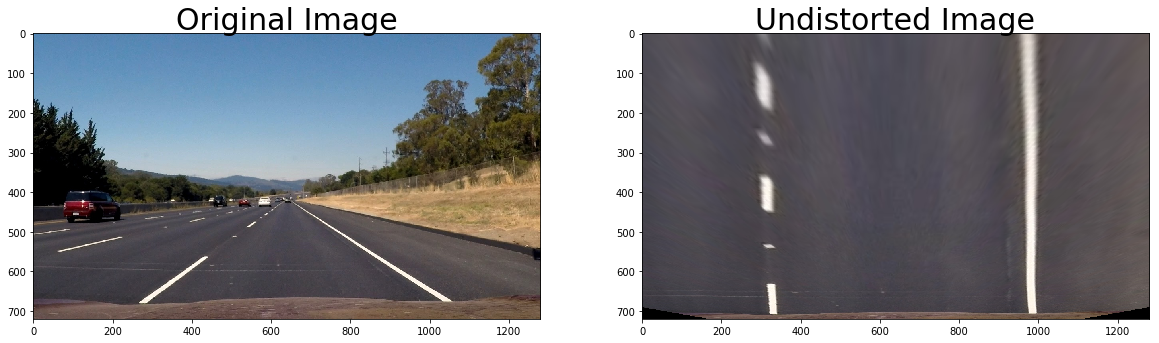

In [6]:
def birds_eye(img):
    img_size = img.shape[1::-1]
    width = img_size[0]
    height = img_size[1]
    # define 4 source points
#     src = np.float32([[688,450],[1110,img_size[1]],[175,img_size[1]],[593,450]])
    src = np.float32([[690,450],[1110,img_size[1]],[175,img_size[1]],[595,450]])


    offset = 300 # offset for dst points
    dst = np.float32([[img_size[0]-offset, 0],[img_size[0]-offset, img_size[1]],
    [offset, img_size[1]],[offset, 0]])
    # use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # euse cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M


road_img = cv2.imread('test_images/straight_lines2.jpg')
road_img = cv2.cvtColor(road_img, cv2.COLOR_BGR2RGB)
threshold_img = combined_thersholds(road_img)
warped = birds_eye(road_img)[0]

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(road_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(warped)
ax2.set_title('Undistorted Image', fontsize=30)

## Create a histogram

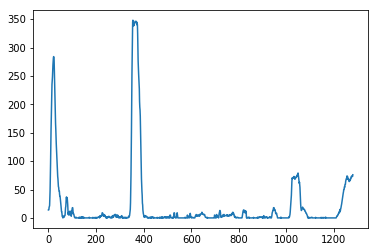

In [7]:
def hist(img):
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # Sum across image pixels vertically - make sure to set an `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    return histogram

# Create histogram of image binary activations
img = cv2.imread('test_images/test4.jpg')
img = combined_thersholds(img)
img = birds_eye(img)[0]
histogram = hist(img)
# Visualize the resulting histogram
plt.plot(histogram)


## Define a class to receive the characteristics of each line detection

In [8]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        # self.detected = False  
        # x values of the last n fits of the line
        # self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        # self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = [] 
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        # self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        # self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        # self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  

## Implement Sliding Windows, Fit a Polynomial and other relevant functions

In [9]:
def sliding_windows_search(binary_warped, left_line: Line, right_line: Line):
    # Take a histogram of the bottom half of the image
    histogram = hist(binary_warped)
    # Create an output image to draw on and visualize the result
    # out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Sanity check - lane width
    lane_width = rightx_base - leftx_base
    if  not (600 < lane_width < 800):
        return left_line, right_line

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    left_line.allx = nonzerox[left_lane_inds]
    left_line.ally = nonzeroy[left_lane_inds] 
    right_line.allx = nonzerox[right_lane_inds]
    right_line.ally = nonzeroy[right_lane_inds]

    return left_line, right_line

def search_around_poly(binary_warped, left_line, right_line):
    left_fit = left_line.best_fit[-1]
    right_fit = right_line.best_fit[-1]
    #     
    # if not any(left_fit) or not any(right_fit):
    #     raise Exception('Line fits were empty')

    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    margin = 10

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0] * (nonzeroy ** 2) + left_fit[1] * nonzeroy +
                                   left_fit[2] - margin)) & (nonzerox < (left_fit[0] * (nonzeroy ** 2) +
                                                                         left_fit[1] * nonzeroy + left_fit[
                                                                             2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0] * (nonzeroy ** 2) + right_fit[1] * nonzeroy +
                                    right_fit[2] - margin)) & (nonzerox < (right_fit[0] * (nonzeroy ** 2) +
                                    right_fit[2] - margin)) & (nonzerox < (right_fit[0] * (nonzeroy ** 2) +
                                                                           right_fit[1] * nonzeroy + right_fit[
                                                                               2] + margin)))
    if not any(left_lane_inds) or not any(right_lane_inds):
        raise exec("Could not find lanes around")
    # Again, extract left and right line pixel positions
    left_line.allx = nonzerox[left_lane_inds]
    left_line.ally = nonzeroy[left_lane_inds]
    right_line.allx = nonzerox[right_lane_inds]
    right_line.ally = nonzeroy[right_lane_inds]

    return left_line, right_line

def fit_polynomial(img_shape, left_line: Line, right_line: Line):
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    
    left_fit = np.polyfit(left_line.ally, left_line.allx, 2)
    right_fit = np.polyfit(right_line.ally, right_line.allx, 2)
    
#     print(left_fit[1]/right_fit[1])
    if 0 < left_fit[1]/right_fit[1] < 3:
        left_line.current_fit = left_fit
        right_line.current_fit = right_fit
        left_line.best_fit = left_line.best_fit[-1:]
        right_line.best_fit = right_line.best_fit[-1:]
        left_line.best_fit.append(left_fit)
        right_line.best_fit.append(right_fit)
    elif not any(left_line.current_fit) or not any(right_line.current_fit):
        raise Exception('Could not polyfit a line')
        
    avg_left_fit = np.mean(left_line.best_fit[-2:], axis=0)
    avg_right_fit = np.mean(right_line.best_fit[-2:], axis=0)    

    left_fitx = avg_left_fit[0]*ploty**2 + avg_left_fit[1]*ploty + avg_left_fit[2]
    right_fitx = avg_right_fit[0]*ploty**2 + avg_right_fit[1]*ploty + avg_right_fit[2]
        
    return ploty, left_fitx, right_fitx

def measure_curvature(line: Line, y_val):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''

    # y_val is where we want radius of curvature to be measured
    # A nice place to measure is the maximum y-value, corresponding to the bottom of the image
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Calculation of R_curve (radius of curvature)
    world_space_a = xm_per_pix / (ym_per_pix ** 2) * line.current_fit[0]
    world_space_b = xm_per_pix / ym_per_pix * line.current_fit[1]
    world_space_y = y_val*ym_per_pix
    curverad = (1 + (2*world_space_a*world_space_y + world_space_b)**2)**1.5 / np.absolute(2*world_space_a)
    
    return curverad

def center_offset(left_line: Line, right_line: Line, y_val, frame_width):
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Find the x values of the lanes at the maximum y
    left_fitx = left_line.current_fit[0]*y_val**2 + left_line.current_fit[1]*y_val + left_line.current_fit[2]
    right_fitx = right_line.current_fit[0]*y_val**2 + right_line.current_fit[1]*y_val + right_line.current_fit[2]
    
    # Calculate the offset
    pixel_offset = (frame_width / 2) - ((right_fitx - left_fitx)/2 + left_fitx)
    meter_offset = xm_per_pix * pixel_offset
    return meter_offset

def fill_lanes(undist_img, ploty=None, left_fitx=None, right_fitx=None, Minv=None):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(undist_img[:,:,0]).astype(np.uint8)   # Drop color dimensions
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    new_warp = cv2.warpPerspective(color_warp, Minv, (undist_img.shape[1], undist_img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist_img, 1, new_warp, 0.3, 0)
    return result


# Process a single frame

1.16873108112


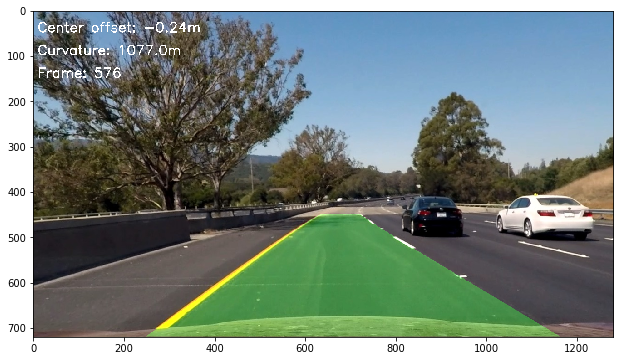

In [13]:
def process_image(img, left_line, right_line, frame_index=0):
    global frame_index_g
    frame_index_g = frame_index
#     cv2.imwrite('video_frames/'+str(frame_index_g)+'.jpg',cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    img_copy = np.copy(img)
    undist = undistort(img_copy)
    img_copy = combined_thersholds(undist)
    binary_warped, M = birds_eye(img_copy)
    Minv = np.linalg.inv(M)

    #Find our lane pixels first
    try:
        search_around_poly(binary_warped, left_line, right_line)
    except:
        sliding_windows_search(binary_warped, left_line, right_line)
    
    try:
        ploty, left_fitx, right_fitx = fit_polynomial(binary_warped.shape, left_line, right_line)
    except:
        print('Polyfit failed')
        return img
    
    left_curverad = measure_curvature(left_line_global, img.shape[0])
    right_curverad = measure_curvature(right_line_global, img.shape[0])

    offset = center_offset(left_line_global, right_line_global, img.shape[0], img.shape[1])
    dst = fill_lanes(undist,ploty, left_fitx, right_fitx,Minv)
    
    avg_rad = round(np.mean([left_curverad, right_curverad]),0)
    rad_text = 'Curvature: {}m'.format(avg_rad)
    center_text = 'Center offset: {}m'.format(round(offset,2))
    frame_text = 'Frame: {}'.format(frame_index_g)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(dst, center_text, (10,50), font, 1,(255,255,255),2)
    cv2.putText(dst, rad_text, (10,100), font, 1,(255,255,255),2)
    cv2.putText(dst, frame_text, (10,150), font, 1,(255,255,255),2)
#     cv2.imwrite('output_images/'+str(frame_index_g)+'.jpg',cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))

    frame_index_g += 1
    return dst

frame_number = 576
# road_img = cv2.imread('video_frames/'+str(frame_number)+'.jpg')
road_img = cv2.imread('test_images/test6.jpg')
# road_img = cv2.imread('test_images/straight_lines1.jpg')
left_line_global = Line()
right_line_global = Line()
dst = process_image(road_img, left_line_global, right_line_global, frame_number)
dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)

plt.figure(figsize = (100,6))
plt.imshow(dst, interpolation='nearest')


# Process a video

In [12]:
# Process a video
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output = 'output_videos/project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")#.subclip(19,25)
left_line_global = Line()
right_line_global = Line()
frame_index_g = 0
white_clip = clip1.fl_image(lambda image: process_image(image, left_line_global, right_line_global, frame_index_g)) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

1.25315542089
Moviepy - Building video output_videos/project_video.mp4.
Moviepy - Writing video output_videos/project_video.mp4



t:   0%|          | 2/1260 [00:01<19:59,  1.05it/s, now=None]

1.25315542089
1.18303068971


t:   0%|          | 4/1260 [00:05<30:38,  1.46s/it, now=None]

1.18380635394
1.2139991121


t:   0%|          | 6/1260 [00:09<36:31,  1.75s/it, now=None]

1.03811599451
0.918456972724


t:   1%|          | 8/1260 [00:13<39:11,  1.88s/it, now=None]

0.921441391953
0.915700784949


t:   1%|          | 10/1260 [00:17<40:14,  1.93s/it, now=None]

0.977342127969
1.05245985763


t:   1%|          | 12/1260 [00:21<40:49,  1.96s/it, now=None]

1.09302241485
1.19992253291


t:   1%|          | 14/1260 [00:25<40:16,  1.94s/it, now=None]

1.20408465173
1.01827729502


t:   1%|▏         | 16/1260 [00:28<33:03,  1.59s/it, now=None]

1.02821557528


t:   1%|▏         | 17/1260 [00:29<27:38,  1.33s/it, now=None]

0.927524755295
0.815639025301


t:   2%|▏         | 19/1260 [00:32<34:10,  1.65s/it, now=None]

0.815639025301
0.797487804472


t:   2%|▏         | 21/1260 [00:36<37:48,  1.83s/it, now=None]

0.861170674754
0.873892703939


t:   2%|▏         | 23/1260 [00:40<39:18,  1.91s/it, now=None]

0.886968652029
0.924059710705


t:   2%|▏         | 25/1260 [00:44<40:03,  1.95s/it, now=None]

0.940479341776
1.11654553612


t:   2%|▏         | 27/1260 [00:48<40:01,  1.95s/it, now=None]

1.1840098878
1.25030599509


t:   2%|▏         | 29/1260 [00:52<40:11,  1.96s/it, now=None]

1.2351205926
1.09276309431


t:   2%|▏         | 31/1260 [00:56<40:26,  1.97s/it, now=None]

1.15325337029
0.972475475221


t:   3%|▎         | 33/1260 [01:00<40:32,  1.98s/it, now=None]

0.892992792125
0.914624859297


t:   3%|▎         | 35/1260 [01:04<40:40,  1.99s/it, now=None]

1.04266232857
1.06890640614


t:   3%|▎         | 37/1260 [01:08<40:49,  2.00s/it, now=None]

1.08109473099
1.04441183365


t:   3%|▎         | 39/1260 [01:12<40:50,  2.01s/it, now=None]

1.01099878042
1.06232716528


t:   3%|▎         | 41/1260 [01:16<40:33,  2.00s/it, now=None]

1.06232716528
1.06232716528


t:   3%|▎         | 43/1260 [01:20<40:17,  1.99s/it, now=None]

1.06232716528
1.06232716528


t:   4%|▎         | 45/1260 [01:24<39:45,  1.96s/it, now=None]

0.902297527152
0.906545525073


t:   4%|▎         | 47/1260 [01:28<40:05,  1.98s/it, now=None]

0.921841770687
0.995650075146


t:   4%|▍         | 49/1260 [01:32<39:40,  1.97s/it, now=None]

0.970170689345
0.982211213875


t:   4%|▍         | 51/1260 [01:36<39:12,  1.95s/it, now=None]

0.934561209988
0.926316041763


t:   4%|▍         | 53/1260 [01:40<39:03,  1.94s/it, now=None]

0.909971642373
0.920695950145


t:   4%|▍         | 55/1260 [01:44<38:41,  1.93s/it, now=None]

0.920695950145
0.920695950145


t:   5%|▍         | 57/1260 [01:47<38:05,  1.90s/it, now=None]

0.920695950145
0.848112884168


t:   5%|▍         | 59/1260 [01:51<38:08,  1.91s/it, now=None]

0.881678440078
0.932867064879


t:   5%|▍         | 61/1260 [01:55<37:57,  1.90s/it, now=None]

0.867602518216
0.831337612674


t:   5%|▌         | 63/1260 [01:59<38:08,  1.91s/it, now=None]

0.795025468074
0.793454507791


t:   5%|▌         | 65/1260 [02:03<38:03,  1.91s/it, now=None]

0.716103272445
0.723552979337


t:   5%|▌         | 67/1260 [02:06<37:58,  1.91s/it, now=None]

0.723552979337
0.723552979337


t:   5%|▌         | 69/1260 [02:10<37:34,  1.89s/it, now=None]

0.723552979337
0.723552979337


t:   6%|▌         | 71/1260 [02:14<37:45,  1.91s/it, now=None]

0.723552979337
0.742974833817


t:   6%|▌         | 73/1260 [02:18<37:49,  1.91s/it, now=None]

0.737937388204
0.730253614836


t:   6%|▌         | 75/1260 [02:21<36:29,  1.85s/it, now=None]

0.734834433018


t:   6%|▌         | 76/1260 [02:23<36:00,  1.82s/it, now=None]

0.740280748034
0.76949850509


t:   6%|▌         | 78/1260 [02:27<36:34,  1.86s/it, now=None]

0.806651360517
0.805660590827


t:   6%|▋         | 80/1260 [02:31<37:28,  1.91s/it, now=None]

0.805660590827
0.805660590827


t:   7%|▋         | 82/1260 [02:35<37:23,  1.90s/it, now=None]

0.713323184451


t:   7%|▋         | 83/1260 [02:35<30:25,  1.55s/it, now=None]

0.682903731852


t:   7%|▋         | 84/1260 [02:36<25:18,  1.29s/it, now=None]

0.720638453271


t:   7%|▋         | 85/1260 [02:37<21:45,  1.11s/it, now=None]

0.74554491347


t:   7%|▋         | 86/1260 [02:37<19:27,  1.01it/s, now=None]

0.835731784471


t:   7%|▋         | 87/1260 [02:38<17:38,  1.11it/s, now=None]

0.876678533372


t:   7%|▋         | 88/1260 [02:39<16:22,  1.19it/s, now=None]

0.889926149087


t:   7%|▋         | 89/1260 [02:40<15:28,  1.26it/s, now=None]

0.860693408273


t:   7%|▋         | 90/1260 [02:40<14:51,  1.31it/s, now=None]

0.952829681513


t:   7%|▋         | 91/1260 [02:41<14:22,  1.36it/s, now=None]

0.952829681513


t:   7%|▋         | 92/1260 [02:42<14:01,  1.39it/s, now=None]

0.952829681513


t:   7%|▋         | 93/1260 [02:42<13:46,  1.41it/s, now=None]

0.952829681513


t:   7%|▋         | 94/1260 [02:43<13:34,  1.43it/s, now=None]

0.952829681513


t:   8%|▊         | 95/1260 [02:44<13:30,  1.44it/s, now=None]

0.857481239975


t:   8%|▊         | 96/1260 [02:44<13:26,  1.44it/s, now=None]

0.852296478552


t:   8%|▊         | 97/1260 [02:45<13:20,  1.45it/s, now=None]

0.881637683375


t:   8%|▊         | 98/1260 [02:46<13:19,  1.45it/s, now=None]

0.925495906391


t:   8%|▊         | 99/1260 [02:46<13:18,  1.45it/s, now=None]

0.919793536516


t:   8%|▊         | 100/1260 [02:47<13:18,  1.45it/s, now=None]

0.844212577712


t:   8%|▊         | 101/1260 [02:48<13:19,  1.45it/s, now=None]

0.850700767177


t:   8%|▊         | 102/1260 [02:48<13:16,  1.45it/s, now=None]

0.920327553658


t:   8%|▊         | 103/1260 [02:49<13:14,  1.46it/s, now=None]

0.896082353137


t:   8%|▊         | 104/1260 [02:50<13:13,  1.46it/s, now=None]

0.885887730883


t:   8%|▊         | 105/1260 [02:50<13:09,  1.46it/s, now=None]

0.885887730883


t:   8%|▊         | 106/1260 [02:51<13:05,  1.47it/s, now=None]

0.885887730883


t:   8%|▊         | 107/1260 [02:52<13:08,  1.46it/s, now=None]

0.94252462615


t:   9%|▊         | 108/1260 [02:53<13:09,  1.46it/s, now=None]

0.866004069105


t:   9%|▊         | 109/1260 [02:53<13:08,  1.46it/s, now=None]

0.813342782732


t:   9%|▊         | 110/1260 [02:54<13:08,  1.46it/s, now=None]

0.845307628369


t:   9%|▉         | 111/1260 [02:55<13:07,  1.46it/s, now=None]

0.878782938229


t:   9%|▉         | 112/1260 [02:55<13:06,  1.46it/s, now=None]

0.972796899588


t:   9%|▉         | 113/1260 [02:56<13:08,  1.45it/s, now=None]

0.982539723412


t:   9%|▉         | 114/1260 [02:57<13:08,  1.45it/s, now=None]

0.902158021699


t:   9%|▉         | 115/1260 [02:57<13:07,  1.45it/s, now=None]

0.898609506814


t:   9%|▉         | 116/1260 [02:58<13:06,  1.45it/s, now=None]

0.91769972862


t:   9%|▉         | 117/1260 [02:59<13:03,  1.46it/s, now=None]

0.902867635249


t:   9%|▉         | 118/1260 [02:59<12:59,  1.46it/s, now=None]

0.902867635249


t:   9%|▉         | 119/1260 [03:00<12:56,  1.47it/s, now=None]

0.902867635249


t:  10%|▉         | 120/1260 [03:01<12:57,  1.47it/s, now=None]

0.840090026246


t:  10%|▉         | 121/1260 [03:01<12:57,  1.46it/s, now=None]

0.884218035927


t:  10%|▉         | 122/1260 [03:02<12:58,  1.46it/s, now=None]

0.939555373846


t:  10%|▉         | 123/1260 [03:03<12:57,  1.46it/s, now=None]

0.928571804808


t:  10%|▉         | 124/1260 [03:03<12:58,  1.46it/s, now=None]

0.874998156223


t:  10%|▉         | 125/1260 [03:04<12:57,  1.46it/s, now=None]

0.862783870261


t:  10%|█         | 126/1260 [03:05<12:57,  1.46it/s, now=None]

0.866295742018


t:  10%|█         | 127/1260 [03:06<12:55,  1.46it/s, now=None]

0.893642896274


t:  10%|█         | 128/1260 [03:06<12:53,  1.46it/s, now=None]

0.884589227442


t:  10%|█         | 129/1260 [03:07<12:52,  1.46it/s, now=None]

0.878753589669


t:  10%|█         | 130/1260 [03:08<12:50,  1.47it/s, now=None]

0.878753589669


t:  10%|█         | 131/1260 [03:08<12:50,  1.47it/s, now=None]

0.878753589669


t:  10%|█         | 132/1260 [03:09<12:47,  1.47it/s, now=None]

0.878753589669


t:  11%|█         | 133/1260 [03:10<12:45,  1.47it/s, now=None]

0.878753589669


t:  11%|█         | 134/1260 [03:10<12:46,  1.47it/s, now=None]

0.881178173834


t:  11%|█         | 135/1260 [03:11<12:48,  1.46it/s, now=None]

0.834395225082


t:  11%|█         | 136/1260 [03:12<12:47,  1.47it/s, now=None]

0.8444661662


t:  11%|█         | 137/1260 [03:12<12:48,  1.46it/s, now=None]

0.832921605378


t:  11%|█         | 138/1260 [03:13<12:49,  1.46it/s, now=None]

0.893784085532


t:  11%|█         | 139/1260 [03:14<12:49,  1.46it/s, now=None]

0.914873781618


t:  11%|█         | 140/1260 [03:14<12:49,  1.46it/s, now=None]

0.933664716104


t:  11%|█         | 141/1260 [03:15<12:46,  1.46it/s, now=None]

0.974844661845


t:  11%|█▏        | 142/1260 [03:16<12:45,  1.46it/s, now=None]

0.966504672608


t:  11%|█▏        | 143/1260 [03:16<12:42,  1.46it/s, now=None]

0.966504672608


t:  11%|█▏        | 144/1260 [03:17<12:40,  1.47it/s, now=None]

0.966504672608


t:  12%|█▏        | 145/1260 [03:18<12:41,  1.46it/s, now=None]

0.966504672608


t:  12%|█▏        | 146/1260 [03:18<12:40,  1.47it/s, now=None]

0.808688685975


t:  12%|█▏        | 147/1260 [03:19<12:40,  1.46it/s, now=None]

0.909288892599


t:  12%|█▏        | 148/1260 [03:20<12:39,  1.46it/s, now=None]

0.909252488883


t:  12%|█▏        | 149/1260 [03:21<12:40,  1.46it/s, now=None]

0.795832762914


t:  12%|█▏        | 150/1260 [03:21<12:41,  1.46it/s, now=None]

0.814915769312


t:  12%|█▏        | 151/1260 [03:22<12:43,  1.45it/s, now=None]

0.85541982972


t:  12%|█▏        | 152/1260 [03:23<12:41,  1.46it/s, now=None]

0.868403822358


t:  12%|█▏        | 153/1260 [03:23<12:42,  1.45it/s, now=None]

0.914368685263


t:  12%|█▏        | 154/1260 [03:24<12:37,  1.46it/s, now=None]

0.914368685263


t:  12%|█▏        | 155/1260 [03:25<12:36,  1.46it/s, now=None]

0.881260516533


t:  12%|█▏        | 156/1260 [03:25<12:35,  1.46it/s, now=None]

0.881260516533


t:  12%|█▏        | 157/1260 [03:26<12:35,  1.46it/s, now=None]

0.827299823179


t:  13%|█▎        | 158/1260 [03:27<12:29,  1.47it/s, now=None]

0.84654773618


t:  13%|█▎        | 159/1260 [03:27<12:26,  1.47it/s, now=None]

0.88328941908


t:  13%|█▎        | 160/1260 [03:28<12:24,  1.48it/s, now=None]

0.907745473785


t:  13%|█▎        | 161/1260 [03:29<12:21,  1.48it/s, now=None]

0.825378619828


t:  13%|█▎        | 162/1260 [03:29<12:22,  1.48it/s, now=None]

0.904185947676


t:  13%|█▎        | 163/1260 [03:30<12:19,  1.48it/s, now=None]

0.848946324647


t:  13%|█▎        | 164/1260 [03:31<12:18,  1.48it/s, now=None]

0.935927045801


t:  13%|█▎        | 165/1260 [03:31<12:18,  1.48it/s, now=None]

0.909051141796


t:  13%|█▎        | 166/1260 [03:32<12:17,  1.48it/s, now=None]

0.793447139059


t:  13%|█▎        | 167/1260 [03:33<12:17,  1.48it/s, now=None]

0.793447139059


t:  13%|█▎        | 168/1260 [03:33<12:14,  1.49it/s, now=None]

0.793447139059


t:  13%|█▎        | 169/1260 [03:34<12:15,  1.48it/s, now=None]

0.793447139059


t:  13%|█▎        | 170/1260 [03:35<12:19,  1.47it/s, now=None]

0.761326149954


t:  14%|█▎        | 171/1260 [03:35<12:17,  1.48it/s, now=None]

0.750714587306


t:  14%|█▎        | 172/1260 [03:36<12:16,  1.48it/s, now=None]

0.746906455205


t:  14%|█▎        | 173/1260 [03:37<12:17,  1.47it/s, now=None]

0.745749377138


t:  14%|█▍        | 174/1260 [03:38<12:16,  1.48it/s, now=None]

0.740009161662


t:  14%|█▍        | 175/1260 [03:38<12:13,  1.48it/s, now=None]

0.705993206212


t:  14%|█▍        | 176/1260 [03:39<12:11,  1.48it/s, now=None]

0.747766698363


t:  14%|█▍        | 177/1260 [03:40<12:11,  1.48it/s, now=None]

0.745611324244


t:  14%|█▍        | 178/1260 [03:40<12:10,  1.48it/s, now=None]

0.784968146471


t:  14%|█▍        | 179/1260 [03:41<12:08,  1.48it/s, now=None]

0.753320377728


t:  14%|█▍        | 180/1260 [03:42<12:08,  1.48it/s, now=None]

0.751789283136


t:  14%|█▍        | 181/1260 [03:42<12:07,  1.48it/s, now=None]

0.761417725202


t:  14%|█▍        | 182/1260 [03:43<12:07,  1.48it/s, now=None]

0.795271941649


t:  15%|█▍        | 183/1260 [03:44<12:05,  1.48it/s, now=None]

0.850388483465


t:  15%|█▍        | 184/1260 [03:44<12:05,  1.48it/s, now=None]

0.85326580885


t:  15%|█▍        | 185/1260 [03:45<12:04,  1.48it/s, now=None]

0.842342139774


t:  15%|█▍        | 186/1260 [03:46<12:03,  1.49it/s, now=None]

0.841320864658


t:  15%|█▍        | 187/1260 [03:46<12:02,  1.48it/s, now=None]

0.819445157769


t:  15%|█▍        | 188/1260 [03:47<12:00,  1.49it/s, now=None]

0.835469027557


t:  15%|█▌        | 189/1260 [03:48<12:01,  1.48it/s, now=None]

0.819993654168


t:  15%|█▌        | 190/1260 [03:48<11:58,  1.49it/s, now=None]

0.819993654168


t:  15%|█▌        | 191/1260 [03:49<11:56,  1.49it/s, now=None]

0.819993654168


t:  15%|█▌        | 192/1260 [03:50<11:55,  1.49it/s, now=None]

0.819993654168


t:  15%|█▌        | 193/1260 [03:50<11:53,  1.50it/s, now=None]

0.819993654168


t:  15%|█▌        | 194/1260 [03:51<11:52,  1.50it/s, now=None]

0.819993654168


t:  15%|█▌        | 195/1260 [03:52<11:51,  1.50it/s, now=None]

0.819993654168


t:  16%|█▌        | 196/1260 [03:52<11:53,  1.49it/s, now=None]

0.787838880625


t:  16%|█▌        | 197/1260 [03:53<12:09,  1.46it/s, now=None]

0.863610705455


t:  16%|█▌        | 198/1260 [03:54<12:40,  1.40it/s, now=None]

0.92662667987


t:  16%|█▌        | 199/1260 [03:55<12:33,  1.41it/s, now=None]

0.909391659369


t:  16%|█▌        | 200/1260 [03:55<12:20,  1.43it/s, now=None]

1.00758410943


t:  16%|█▌        | 201/1260 [03:56<12:20,  1.43it/s, now=None]

0.989893380765


t:  16%|█▌        | 202/1260 [03:57<12:14,  1.44it/s, now=None]

1.0396696943


t:  16%|█▌        | 203/1260 [03:57<12:10,  1.45it/s, now=None]

1.00242689085


t:  16%|█▌        | 204/1260 [03:58<12:05,  1.46it/s, now=None]

0.930910005811


t:  16%|█▋        | 205/1260 [03:59<12:03,  1.46it/s, now=None]

0.944101272992


t:  16%|█▋        | 206/1260 [03:59<12:02,  1.46it/s, now=None]

0.843364506642


t:  16%|█▋        | 207/1260 [04:00<11:59,  1.46it/s, now=None]

0.834988298737


t:  17%|█▋        | 208/1260 [04:01<11:56,  1.47it/s, now=None]

0.919465740058


t:  17%|█▋        | 209/1260 [04:01<11:52,  1.47it/s, now=None]

0.923889649875


t:  17%|█▋        | 210/1260 [04:02<11:51,  1.48it/s, now=None]

0.933780784878


t:  17%|█▋        | 211/1260 [04:03<11:48,  1.48it/s, now=None]

1.00760262905


t:  17%|█▋        | 212/1260 [04:03<11:47,  1.48it/s, now=None]

1.0689786426


t:  17%|█▋        | 213/1260 [04:04<11:55,  1.46it/s, now=None]

1.04927959908


t:  17%|█▋        | 214/1260 [04:05<11:57,  1.46it/s, now=None]

1.06335534652


t:  17%|█▋        | 215/1260 [04:05<11:57,  1.46it/s, now=None]

1.09562155052


t:  17%|█▋        | 216/1260 [04:06<11:52,  1.47it/s, now=None]

1.05947227371


t:  17%|█▋        | 217/1260 [04:07<11:49,  1.47it/s, now=None]

1.05947227371


t:  17%|█▋        | 218/1260 [04:07<11:44,  1.48it/s, now=None]

1.05947227371


t:  17%|█▋        | 219/1260 [04:08<11:43,  1.48it/s, now=None]

0.924174778022


t:  17%|█▋        | 220/1260 [04:09<11:42,  1.48it/s, now=None]

0.941686322462


t:  18%|█▊        | 221/1260 [04:09<11:42,  1.48it/s, now=None]

0.931667205703


t:  18%|█▊        | 222/1260 [04:10<11:43,  1.48it/s, now=None]

0.959453139065


t:  18%|█▊        | 223/1260 [04:11<11:41,  1.48it/s, now=None]

0.9932538029


t:  18%|█▊        | 224/1260 [04:11<11:39,  1.48it/s, now=None]

0.991526508045


t:  18%|█▊        | 225/1260 [04:12<11:39,  1.48it/s, now=None]

0.867702174837


t:  18%|█▊        | 226/1260 [04:13<11:39,  1.48it/s, now=None]

0.894742211933


t:  18%|█▊        | 227/1260 [04:14<11:39,  1.48it/s, now=None]

0.88166917603


t:  18%|█▊        | 228/1260 [04:14<11:35,  1.48it/s, now=None]

0.88166917603


t:  18%|█▊        | 229/1260 [04:15<11:39,  1.47it/s, now=None]

0.88166917603


t:  18%|█▊        | 230/1260 [04:16<11:35,  1.48it/s, now=None]

0.88166917603


t:  18%|█▊        | 231/1260 [04:16<11:35,  1.48it/s, now=None]

0.785458964951


t:  18%|█▊        | 232/1260 [04:17<11:34,  1.48it/s, now=None]

0.791222150617


t:  18%|█▊        | 233/1260 [04:18<11:34,  1.48it/s, now=None]

0.784176129077


t:  19%|█▊        | 234/1260 [04:18<11:32,  1.48it/s, now=None]

0.789202997228


t:  19%|█▊        | 235/1260 [04:19<11:30,  1.48it/s, now=None]

0.809689693933


t:  19%|█▊        | 236/1260 [04:20<11:31,  1.48it/s, now=None]

0.807680041716


t:  19%|█▉        | 237/1260 [04:20<11:31,  1.48it/s, now=None]

0.775884290803


t:  19%|█▉        | 238/1260 [04:21<11:31,  1.48it/s, now=None]

0.783214199071


t:  19%|█▉        | 239/1260 [04:22<11:29,  1.48it/s, now=None]

0.76118730331


t:  19%|█▉        | 240/1260 [04:22<11:35,  1.47it/s, now=None]

0.751534906908


t:  19%|█▉        | 241/1260 [04:23<11:33,  1.47it/s, now=None]

0.751534906908


t:  19%|█▉        | 242/1260 [04:24<11:28,  1.48it/s, now=None]

0.751534906908


t:  19%|█▉        | 243/1260 [04:24<11:31,  1.47it/s, now=None]

0.777277346979


t:  19%|█▉        | 244/1260 [04:25<11:28,  1.47it/s, now=None]

0.7913217023


t:  19%|█▉        | 245/1260 [04:26<11:33,  1.46it/s, now=None]

0.803083880377


t:  20%|█▉        | 246/1260 [04:26<11:33,  1.46it/s, now=None]

0.768603185847


t:  20%|█▉        | 247/1260 [04:27<11:29,  1.47it/s, now=None]

0.753577644051


t:  20%|█▉        | 248/1260 [04:28<11:29,  1.47it/s, now=None]

0.78032740359


t:  20%|█▉        | 249/1260 [04:28<11:28,  1.47it/s, now=None]

0.701882168767


t:  20%|█▉        | 250/1260 [04:29<11:25,  1.47it/s, now=None]

0.744078360566


t:  20%|█▉        | 251/1260 [04:30<11:24,  1.47it/s, now=None]

0.725608694779


t:  20%|██        | 252/1260 [04:30<11:22,  1.48it/s, now=None]

0.736356677147


t:  20%|██        | 253/1260 [04:31<11:19,  1.48it/s, now=None]

0.736356677147


t:  20%|██        | 254/1260 [04:32<11:16,  1.49it/s, now=None]

0.736356677147


t:  20%|██        | 255/1260 [04:32<11:15,  1.49it/s, now=None]

0.73054938554


t:  20%|██        | 256/1260 [04:33<11:16,  1.48it/s, now=None]

0.735877793286


t:  20%|██        | 257/1260 [04:34<11:17,  1.48it/s, now=None]

0.746816800119


t:  20%|██        | 258/1260 [04:35<11:16,  1.48it/s, now=None]

0.711668026548


t:  21%|██        | 259/1260 [04:35<11:17,  1.48it/s, now=None]

0.709598055412


t:  21%|██        | 260/1260 [04:36<11:16,  1.48it/s, now=None]

0.719016221892


t:  21%|██        | 261/1260 [04:37<11:15,  1.48it/s, now=None]

0.695994068637


t:  21%|██        | 262/1260 [04:37<11:14,  1.48it/s, now=None]

0.765821231932


t:  21%|██        | 263/1260 [04:38<11:14,  1.48it/s, now=None]

0.731581317239


t:  21%|██        | 264/1260 [04:39<11:13,  1.48it/s, now=None]

0.723630209261


t:  21%|██        | 265/1260 [04:39<11:13,  1.48it/s, now=None]

0.709035577911


t:  21%|██        | 266/1260 [04:40<11:12,  1.48it/s, now=None]

0.712764250885


t:  21%|██        | 267/1260 [04:41<11:11,  1.48it/s, now=None]

0.761216883578


t:  21%|██▏       | 268/1260 [04:41<11:08,  1.48it/s, now=None]

0.785441135383


t:  21%|██▏       | 269/1260 [04:42<11:09,  1.48it/s, now=None]

0.82685375104


t:  21%|██▏       | 270/1260 [04:43<11:09,  1.48it/s, now=None]

0.838966811509


t:  22%|██▏       | 271/1260 [04:43<11:07,  1.48it/s, now=None]

0.879700392008


t:  22%|██▏       | 272/1260 [04:44<11:06,  1.48it/s, now=None]

0.84500622194


t:  22%|██▏       | 273/1260 [04:45<11:07,  1.48it/s, now=None]

0.781196529921


t:  22%|██▏       | 274/1260 [04:45<11:07,  1.48it/s, now=None]

0.733281079014


t:  22%|██▏       | 275/1260 [04:46<11:06,  1.48it/s, now=None]

0.676664514985


t:  22%|██▏       | 276/1260 [04:47<11:02,  1.49it/s, now=None]

0.676664514985


t:  22%|██▏       | 277/1260 [04:47<11:03,  1.48it/s, now=None]

0.680516169483


t:  22%|██▏       | 278/1260 [04:48<11:03,  1.48it/s, now=None]

0.670938569938


t:  22%|██▏       | 279/1260 [04:49<11:05,  1.47it/s, now=None]

0.706370072253


t:  22%|██▏       | 280/1260 [04:49<11:06,  1.47it/s, now=None]

0.707177022732


t:  22%|██▏       | 281/1260 [04:50<11:04,  1.47it/s, now=None]

0.734978983418


t:  22%|██▏       | 282/1260 [04:51<11:03,  1.47it/s, now=None]

0.693871318328


t:  22%|██▏       | 283/1260 [04:51<11:03,  1.47it/s, now=None]

0.679096469835


t:  23%|██▎       | 284/1260 [04:52<11:01,  1.48it/s, now=None]

0.696552114231


t:  23%|██▎       | 285/1260 [04:53<11:01,  1.47it/s, now=None]

0.660219925388


t:  23%|██▎       | 286/1260 [04:53<11:00,  1.47it/s, now=None]

0.701349147144


t:  23%|██▎       | 287/1260 [04:54<10:59,  1.48it/s, now=None]

0.708555099704


t:  23%|██▎       | 288/1260 [04:55<10:58,  1.48it/s, now=None]

0.658256361937


t:  23%|██▎       | 289/1260 [04:56<11:00,  1.47it/s, now=None]

0.661079731249


t:  23%|██▎       | 290/1260 [04:56<10:59,  1.47it/s, now=None]

0.589731891606


t:  23%|██▎       | 291/1260 [04:57<10:57,  1.47it/s, now=None]

0.593879139705


t:  23%|██▎       | 292/1260 [04:58<10:55,  1.48it/s, now=None]

0.612954714924


t:  23%|██▎       | 293/1260 [04:58<10:56,  1.47it/s, now=None]

0.620005161829


t:  23%|██▎       | 294/1260 [04:59<10:57,  1.47it/s, now=None]

0.646474463829


t:  23%|██▎       | 295/1260 [05:00<10:56,  1.47it/s, now=None]

0.594669128198


t:  23%|██▎       | 296/1260 [05:00<10:53,  1.47it/s, now=None]

0.665789766854


t:  24%|██▎       | 297/1260 [05:01<10:51,  1.48it/s, now=None]

0.564012319819


t:  24%|██▎       | 298/1260 [05:02<10:50,  1.48it/s, now=None]

0.613393672314


t:  24%|██▎       | 299/1260 [05:02<10:50,  1.48it/s, now=None]

0.567233422407


t:  24%|██▍       | 300/1260 [05:03<10:48,  1.48it/s, now=None]

0.58243221306


t:  24%|██▍       | 301/1260 [05:04<10:48,  1.48it/s, now=None]

0.585624105225


t:  24%|██▍       | 302/1260 [05:04<10:47,  1.48it/s, now=None]

0.580737252488


t:  24%|██▍       | 303/1260 [05:05<10:47,  1.48it/s, now=None]

0.615498911216


t:  24%|██▍       | 304/1260 [05:06<10:52,  1.46it/s, now=None]

0.669053724624


t:  24%|██▍       | 305/1260 [05:06<10:53,  1.46it/s, now=None]

0.684243365132


t:  24%|██▍       | 306/1260 [05:07<10:51,  1.46it/s, now=None]

0.77084626145


t:  24%|██▍       | 307/1260 [05:08<10:49,  1.47it/s, now=None]

0.693942089026


t:  24%|██▍       | 308/1260 [05:08<10:47,  1.47it/s, now=None]

0.783509452374


t:  25%|██▍       | 309/1260 [05:09<10:44,  1.48it/s, now=None]

0.552436493708


t:  25%|██▍       | 310/1260 [05:10<10:44,  1.47it/s, now=None]

0.504499574539


t:  25%|██▍       | 311/1260 [05:10<10:44,  1.47it/s, now=None]

0.363401545679


t:  25%|██▍       | 312/1260 [05:11<10:41,  1.48it/s, now=None]

0.298598995657


t:  25%|██▍       | 313/1260 [05:12<10:41,  1.48it/s, now=None]

0.311572064285


t:  25%|██▍       | 314/1260 [05:12<10:40,  1.48it/s, now=None]

0.209089622125


t:  25%|██▌       | 315/1260 [05:13<10:40,  1.48it/s, now=None]

0.175914850319


t:  25%|██▌       | 316/1260 [05:14<10:39,  1.48it/s, now=None]

0.155318671649


t:  25%|██▌       | 317/1260 [05:14<10:39,  1.47it/s, now=None]

0.12350075608


t:  25%|██▌       | 318/1260 [05:15<10:37,  1.48it/s, now=None]

0.158086618382


t:  25%|██▌       | 319/1260 [05:16<10:37,  1.48it/s, now=None]

0.0874386786089


t:  25%|██▌       | 320/1260 [05:17<10:36,  1.48it/s, now=None]

0.072143275109


t:  25%|██▌       | 321/1260 [05:17<10:34,  1.48it/s, now=None]

0.03253152986


t:  26%|██▌       | 322/1260 [05:18<10:34,  1.48it/s, now=None]

0.000241971512437


t:  26%|██▌       | 323/1260 [05:19<10:34,  1.48it/s, now=None]

-0.0154272547943


t:  26%|██▌       | 324/1260 [05:19<10:33,  1.48it/s, now=None]

-0.0272876293887


t:  26%|██▌       | 325/1260 [05:20<10:32,  1.48it/s, now=None]

0.00793420464332


t:  26%|██▌       | 326/1260 [05:21<10:32,  1.48it/s, now=None]

-0.0319936600511


t:  26%|██▌       | 327/1260 [05:21<10:31,  1.48it/s, now=None]

-0.0434434026071


t:  26%|██▌       | 328/1260 [05:22<10:28,  1.48it/s, now=None]

-0.0588756921734


t:  26%|██▌       | 329/1260 [05:23<10:29,  1.48it/s, now=None]

-0.0656487220254


t:  26%|██▌       | 330/1260 [05:23<10:27,  1.48it/s, now=None]

-0.00248351556351


t:  26%|██▋       | 331/1260 [05:24<10:27,  1.48it/s, now=None]

-0.0969369794157


t:  26%|██▋       | 332/1260 [05:25<10:27,  1.48it/s, now=None]

-0.14754707527


t:  26%|██▋       | 333/1260 [05:25<10:26,  1.48it/s, now=None]

-0.187140670538


t:  27%|██▋       | 334/1260 [05:26<10:34,  1.46it/s, now=None]

-0.152788101471


t:  27%|██▋       | 335/1260 [05:27<10:34,  1.46it/s, now=None]

-0.132013133988


t:  27%|██▋       | 336/1260 [05:27<10:30,  1.47it/s, now=None]

-0.149980117642


t:  27%|██▋       | 337/1260 [05:28<10:27,  1.47it/s, now=None]

-0.0341802302221


t:  27%|██▋       | 338/1260 [05:29<10:25,  1.47it/s, now=None]

-0.0500370774795


t:  27%|██▋       | 339/1260 [05:29<10:24,  1.47it/s, now=None]

-0.132472408097


t:  27%|██▋       | 340/1260 [05:30<10:22,  1.48it/s, now=None]

-0.119858568757


t:  27%|██▋       | 341/1260 [05:31<10:21,  1.48it/s, now=None]

-0.126159963618


t:  27%|██▋       | 342/1260 [05:31<10:18,  1.49it/s, now=None]

-0.0803720768322


t:  27%|██▋       | 343/1260 [05:32<10:18,  1.48it/s, now=None]

-0.0382370292891


t:  27%|██▋       | 344/1260 [05:33<10:19,  1.48it/s, now=None]

0.0109011189793


t:  27%|██▋       | 345/1260 [05:33<10:19,  1.48it/s, now=None]

0.121759125781


t:  27%|██▋       | 346/1260 [05:34<10:18,  1.48it/s, now=None]

0.150661538852


t:  28%|██▊       | 347/1260 [05:35<10:17,  1.48it/s, now=None]

0.237109145174


t:  28%|██▊       | 348/1260 [05:35<10:16,  1.48it/s, now=None]

0.148758903976


t:  28%|██▊       | 349/1260 [05:36<10:17,  1.48it/s, now=None]

0.204050357921


t:  28%|██▊       | 350/1260 [05:37<10:16,  1.48it/s, now=None]

0.212362525525


t:  28%|██▊       | 351/1260 [05:38<10:15,  1.48it/s, now=None]

0.256302007142


t:  28%|██▊       | 352/1260 [05:38<10:25,  1.45it/s, now=None]

0.287690184965


t:  28%|██▊       | 353/1260 [05:39<10:26,  1.45it/s, now=None]

0.283844261464


t:  28%|██▊       | 354/1260 [05:40<10:24,  1.45it/s, now=None]

0.329398905585


t:  28%|██▊       | 355/1260 [05:40<10:19,  1.46it/s, now=None]

0.165607270692


t:  28%|██▊       | 356/1260 [05:41<10:18,  1.46it/s, now=None]

0.146415929475


t:  28%|██▊       | 357/1260 [05:42<10:15,  1.47it/s, now=None]

0.134160713678


t:  28%|██▊       | 358/1260 [05:42<10:12,  1.47it/s, now=None]

-0.318359748381


t:  28%|██▊       | 359/1260 [05:43<10:10,  1.48it/s, now=None]

-0.26444358452


t:  29%|██▊       | 360/1260 [05:44<10:08,  1.48it/s, now=None]

-0.442067665718


t:  29%|██▊       | 361/1260 [05:44<10:07,  1.48it/s, now=None]

-0.493487833767


t:  29%|██▊       | 362/1260 [05:45<10:07,  1.48it/s, now=None]

-0.653081526149


t:  29%|██▉       | 363/1260 [05:46<10:06,  1.48it/s, now=None]

-0.963085956517


t:  29%|██▉       | 364/1260 [05:46<10:06,  1.48it/s, now=None]

-1.1632102221


t:  29%|██▉       | 365/1260 [05:47<10:06,  1.48it/s, now=None]

-1.10112538236


t:  29%|██▉       | 366/1260 [05:48<10:06,  1.47it/s, now=None]

-1.26522286301


t:  29%|██▉       | 367/1260 [05:48<10:06,  1.47it/s, now=None]

-1.19487532941


t:  29%|██▉       | 368/1260 [05:49<10:06,  1.47it/s, now=None]

-1.20862689534


t:  29%|██▉       | 369/1260 [05:50<10:04,  1.47it/s, now=None]

-1.15642304022


t:  29%|██▉       | 370/1260 [05:50<10:03,  1.48it/s, now=None]

-0.782309476074


t:  29%|██▉       | 371/1260 [05:51<10:03,  1.47it/s, now=None]

-0.810094265815


t:  30%|██▉       | 372/1260 [05:52<10:04,  1.47it/s, now=None]

-0.822878041864


t:  30%|██▉       | 373/1260 [05:52<10:02,  1.47it/s, now=None]

-0.706410924229


t:  30%|██▉       | 374/1260 [05:53<10:00,  1.47it/s, now=None]

-0.767858217902


t:  30%|██▉       | 375/1260 [05:54<10:01,  1.47it/s, now=None]

-0.889528800377


t:  30%|██▉       | 376/1260 [05:55<09:59,  1.47it/s, now=None]

-0.614731578578


t:  30%|██▉       | 377/1260 [05:55<09:57,  1.48it/s, now=None]

-0.472152106938


t:  30%|███       | 378/1260 [05:56<10:02,  1.46it/s, now=None]

-0.430988981516


t:  30%|███       | 379/1260 [05:57<10:01,  1.47it/s, now=None]

-0.270590589056


t:  30%|███       | 380/1260 [05:57<09:58,  1.47it/s, now=None]

-0.0597402037808


t:  30%|███       | 381/1260 [05:58<09:57,  1.47it/s, now=None]

0.082001639207


t:  30%|███       | 382/1260 [05:59<09:57,  1.47it/s, now=None]

0.227160345462


t:  30%|███       | 383/1260 [05:59<09:55,  1.47it/s, now=None]

0.531117143792


t:  30%|███       | 384/1260 [06:00<09:57,  1.47it/s, now=None]

0.286563610132


t:  31%|███       | 385/1260 [06:01<09:54,  1.47it/s, now=None]

0.289914427288


t:  31%|███       | 386/1260 [06:01<09:52,  1.48it/s, now=None]

0.418467947675


t:  31%|███       | 387/1260 [06:02<09:51,  1.48it/s, now=None]

0.432009532389


t:  31%|███       | 388/1260 [06:03<09:49,  1.48it/s, now=None]

0.573676164447


t:  31%|███       | 389/1260 [06:03<09:49,  1.48it/s, now=None]

0.644945424553


t:  31%|███       | 390/1260 [06:04<09:49,  1.48it/s, now=None]

0.628311888402


t:  31%|███       | 391/1260 [06:05<09:48,  1.48it/s, now=None]

0.906905675979


t:  31%|███       | 392/1260 [06:05<09:46,  1.48it/s, now=None]

1.99077952834


t:  31%|███       | 393/1260 [06:06<09:44,  1.48it/s, now=None]

-17.6364301405


t:  31%|███▏      | 394/1260 [06:07<09:43,  1.48it/s, now=None]

585.904167155


t:  31%|███▏      | 395/1260 [06:07<09:45,  1.48it/s, now=None]

-4.1885713209


t:  31%|███▏      | 396/1260 [06:08<09:43,  1.48it/s, now=None]

5.81438272622


t:  32%|███▏      | 397/1260 [06:09<09:43,  1.48it/s, now=None]

4.3640135548


t:  32%|███▏      | 398/1260 [06:09<09:41,  1.48it/s, now=None]

5.82092659876


t:  32%|███▏      | 399/1260 [06:10<09:41,  1.48it/s, now=None]

-50.4804190269


t:  32%|███▏      | 400/1260 [06:11<09:41,  1.48it/s, now=None]

12.8130559153


t:  32%|███▏      | 401/1260 [06:11<09:41,  1.48it/s, now=None]

0.745659932079


t:  32%|███▏      | 402/1260 [06:12<09:40,  1.48it/s, now=None]

0.619716347844


t:  32%|███▏      | 403/1260 [06:13<09:40,  1.48it/s, now=None]

0.429261355566


t:  32%|███▏      | 404/1260 [06:14<09:40,  1.47it/s, now=None]

0.453271752386


t:  32%|███▏      | 405/1260 [06:14<09:38,  1.48it/s, now=None]

0.942343982069


t:  32%|███▏      | 406/1260 [06:15<09:38,  1.48it/s, now=None]

1.51910394686


t:  32%|███▏      | 407/1260 [06:16<09:36,  1.48it/s, now=None]

-1.99700772348


t:  32%|███▏      | 408/1260 [06:16<09:35,  1.48it/s, now=None]

-3.3328339751


t:  32%|███▏      | 409/1260 [06:17<09:35,  1.48it/s, now=None]

-9.27535739855


t:  33%|███▎      | 410/1260 [06:18<09:35,  1.48it/s, now=None]

1.80370440659


t:  33%|███▎      | 411/1260 [06:18<09:34,  1.48it/s, now=None]

9.43751937263


t:  33%|███▎      | 412/1260 [06:19<09:34,  1.48it/s, now=None]

1.57110353495


t:  33%|███▎      | 413/1260 [06:20<09:35,  1.47it/s, now=None]

0.800625957064


t:  33%|███▎      | 414/1260 [06:20<09:35,  1.47it/s, now=None]

0.867960240813


t:  33%|███▎      | 415/1260 [06:21<09:33,  1.47it/s, now=None]

0.739303921649


t:  33%|███▎      | 416/1260 [06:22<09:32,  1.47it/s, now=None]

1.50738651986


t:  33%|███▎      | 417/1260 [06:22<09:30,  1.48it/s, now=None]

2.17844330982


t:  33%|███▎      | 418/1260 [06:23<09:30,  1.47it/s, now=None]

13.5460088741


t:  33%|███▎      | 419/1260 [06:24<09:32,  1.47it/s, now=None]

-117.871683292


t:  33%|███▎      | 420/1260 [06:24<09:30,  1.47it/s, now=None]

-39.0880121379


t:  33%|███▎      | 421/1260 [06:25<09:29,  1.47it/s, now=None]

2.18602092791


t:  33%|███▎      | 422/1260 [06:26<09:33,  1.46it/s, now=None]

4.3469169535


t:  34%|███▎      | 423/1260 [06:26<09:33,  1.46it/s, now=None]

0.690062513626


t:  34%|███▎      | 424/1260 [06:27<09:32,  1.46it/s, now=None]

0.74753089712


t:  34%|███▎      | 425/1260 [06:28<09:31,  1.46it/s, now=None]

0.698589954777


t:  34%|███▍      | 426/1260 [06:28<09:27,  1.47it/s, now=None]

0.640549161153


t:  34%|███▍      | 427/1260 [06:29<09:26,  1.47it/s, now=None]

0.706232814928


t:  34%|███▍      | 428/1260 [06:30<09:26,  1.47it/s, now=None]

0.858055320811


t:  34%|███▍      | 429/1260 [06:30<09:25,  1.47it/s, now=None]

1.21304816463


t:  34%|███▍      | 430/1260 [06:31<09:23,  1.47it/s, now=None]

0.655430656687


t:  34%|███▍      | 431/1260 [06:32<09:22,  1.47it/s, now=None]

0.365212950866


t:  34%|███▍      | 432/1260 [06:33<09:21,  1.47it/s, now=None]

0.732046899925


t:  34%|███▍      | 433/1260 [06:33<09:18,  1.48it/s, now=None]

0.292154310198


t:  34%|███▍      | 434/1260 [06:34<09:17,  1.48it/s, now=None]

0.528329325923


t:  35%|███▍      | 435/1260 [06:35<09:17,  1.48it/s, now=None]

0.147049669136


t:  35%|███▍      | 436/1260 [06:35<09:16,  1.48it/s, now=None]

0.0201628321904


t:  35%|███▍      | 437/1260 [06:36<09:15,  1.48it/s, now=None]

-0.0890216061369


t:  35%|███▍      | 438/1260 [06:37<09:14,  1.48it/s, now=None]

-0.413542929232


t:  35%|███▍      | 439/1260 [06:37<09:13,  1.48it/s, now=None]

-0.34777393561


t:  35%|███▍      | 440/1260 [06:38<09:13,  1.48it/s, now=None]

-0.644438352493


t:  35%|███▌      | 441/1260 [06:39<09:12,  1.48it/s, now=None]

-0.490339176271


t:  35%|███▌      | 442/1260 [06:39<09:11,  1.48it/s, now=None]

-0.622340332909


t:  35%|███▌      | 443/1260 [06:40<09:11,  1.48it/s, now=None]

-0.509030087168


t:  35%|███▌      | 444/1260 [06:41<09:11,  1.48it/s, now=None]

-0.489948940764


t:  35%|███▌      | 445/1260 [06:41<09:10,  1.48it/s, now=None]

-0.571605287484


t:  35%|███▌      | 446/1260 [06:42<09:08,  1.48it/s, now=None]

-0.508225533006


t:  35%|███▌      | 447/1260 [06:43<09:08,  1.48it/s, now=None]

-0.38347000261


t:  36%|███▌      | 448/1260 [06:43<09:08,  1.48it/s, now=None]

-0.407314946398


t:  36%|███▌      | 449/1260 [06:44<09:08,  1.48it/s, now=None]

-0.600931973735


t:  36%|███▌      | 450/1260 [06:45<09:07,  1.48it/s, now=None]

-0.779197841639


t:  36%|███▌      | 451/1260 [06:45<09:06,  1.48it/s, now=None]

-0.553704876798


t:  36%|███▌      | 452/1260 [06:46<09:06,  1.48it/s, now=None]

-0.411172344925


t:  36%|███▌      | 453/1260 [06:47<09:05,  1.48it/s, now=None]

-0.326319248644


t:  36%|███▌      | 454/1260 [06:47<09:05,  1.48it/s, now=None]

-0.133533966144


t:  36%|███▌      | 455/1260 [06:48<09:03,  1.48it/s, now=None]

-0.170188415027


t:  36%|███▌      | 456/1260 [06:49<09:03,  1.48it/s, now=None]

0.00348657448955


t:  36%|███▋      | 457/1260 [06:49<09:03,  1.48it/s, now=None]

0.00750456537034


t:  36%|███▋      | 458/1260 [06:50<09:02,  1.48it/s, now=None]

0.159437204858


t:  36%|███▋      | 459/1260 [06:51<09:02,  1.48it/s, now=None]

0.0778375069285


t:  37%|███▋      | 460/1260 [06:51<09:01,  1.48it/s, now=None]

0.0866273510976


t:  37%|███▋      | 461/1260 [06:52<09:01,  1.47it/s, now=None]

0.55094302621


t:  37%|███▋      | 462/1260 [06:53<08:59,  1.48it/s, now=None]

-0.168900126793


t:  37%|███▋      | 463/1260 [06:53<08:59,  1.48it/s, now=None]

-1.31301897723


t:  37%|███▋      | 464/1260 [06:54<09:00,  1.47it/s, now=None]

-1.61533164837


t:  37%|███▋      | 465/1260 [06:55<08:59,  1.47it/s, now=None]

-0.540617284048


t:  37%|███▋      | 466/1260 [06:56<09:01,  1.47it/s, now=None]

-0.396433880023


t:  37%|███▋      | 467/1260 [06:56<08:59,  1.47it/s, now=None]

-0.657636632653


t:  37%|███▋      | 468/1260 [06:57<08:57,  1.47it/s, now=None]

-0.663524780201


t:  37%|███▋      | 469/1260 [06:58<08:56,  1.47it/s, now=None]

-0.294996749348


t:  37%|███▋      | 470/1260 [06:58<08:55,  1.48it/s, now=None]

0.0884424392658


t:  37%|███▋      | 471/1260 [06:59<08:53,  1.48it/s, now=None]

-1.82277129421


t:  37%|███▋      | 472/1260 [07:00<08:54,  1.48it/s, now=None]

-0.124378228696


t:  38%|███▊      | 473/1260 [07:00<08:53,  1.47it/s, now=None]

0.241853815092


t:  38%|███▊      | 474/1260 [07:01<08:51,  1.48it/s, now=None]

0.0278098245409


t:  38%|███▊      | 475/1260 [07:02<08:50,  1.48it/s, now=None]

1.83158317132


t:  38%|███▊      | 476/1260 [07:02<08:47,  1.48it/s, now=None]

4.81961394042


t:  38%|███▊      | 477/1260 [07:03<08:46,  1.49it/s, now=None]

4.42235576695


t:  38%|███▊      | 478/1260 [07:04<08:44,  1.49it/s, now=None]

25.6658195262


t:  38%|███▊      | 479/1260 [07:04<08:42,  1.49it/s, now=None]

4.4893098012


t:  38%|███▊      | 480/1260 [07:05<08:42,  1.49it/s, now=None]

0.868321331351


t:  38%|███▊      | 481/1260 [07:06<08:41,  1.49it/s, now=None]

-0.0300847442489


t:  38%|███▊      | 482/1260 [07:06<08:39,  1.50it/s, now=None]

-0.00143319520696


t:  38%|███▊      | 483/1260 [07:07<08:38,  1.50it/s, now=None]

-0.0353554004027


t:  38%|███▊      | 484/1260 [07:08<08:40,  1.49it/s, now=None]

-0.228018808305


t:  38%|███▊      | 485/1260 [07:08<08:39,  1.49it/s, now=None]

-0.0300286449252


t:  39%|███▊      | 486/1260 [07:09<08:40,  1.49it/s, now=None]

0.274105403843


t:  39%|███▊      | 487/1260 [07:10<08:40,  1.48it/s, now=None]

-0.175531716609


t:  39%|███▊      | 488/1260 [07:10<08:40,  1.48it/s, now=None]

-0.320879370922


t:  39%|███▉      | 489/1260 [07:11<08:40,  1.48it/s, now=None]

-0.848041554244


t:  39%|███▉      | 490/1260 [07:12<08:39,  1.48it/s, now=None]

-0.525850121936


t:  39%|███▉      | 491/1260 [07:12<08:39,  1.48it/s, now=None]

-0.474394473107


t:  39%|███▉      | 492/1260 [07:13<08:39,  1.48it/s, now=None]

-0.706317928654


t:  39%|███▉      | 493/1260 [07:14<08:38,  1.48it/s, now=None]

-0.264863536787


t:  39%|███▉      | 494/1260 [07:14<08:37,  1.48it/s, now=None]

0.0368982832827


t:  39%|███▉      | 495/1260 [07:15<08:36,  1.48it/s, now=None]

0.0270337522884


t:  39%|███▉      | 496/1260 [07:16<08:36,  1.48it/s, now=None]

0.326264824067


t:  39%|███▉      | 497/1260 [07:16<08:35,  1.48it/s, now=None]

0.165298777421


t:  40%|███▉      | 498/1260 [07:17<08:34,  1.48it/s, now=None]

0.186592773645


t:  40%|███▉      | 499/1260 [07:18<08:34,  1.48it/s, now=None]

0.189190224715


t:  40%|███▉      | 500/1260 [07:18<08:34,  1.48it/s, now=None]

0.814748284947


t:  40%|███▉      | 501/1260 [07:19<08:33,  1.48it/s, now=None]

1.18198994107


t:  40%|███▉      | 502/1260 [07:20<08:32,  1.48it/s, now=None]

2.28101881914


t:  40%|███▉      | 503/1260 [07:20<08:31,  1.48it/s, now=None]

40.4837611791


t:  40%|████      | 504/1260 [07:21<08:30,  1.48it/s, now=None]

-1.54372048863


t:  40%|████      | 505/1260 [07:22<08:37,  1.46it/s, now=None]

-1.69360430763


t:  40%|████      | 506/1260 [07:23<08:36,  1.46it/s, now=None]

-2.764280085


t:  40%|████      | 507/1260 [07:23<08:34,  1.46it/s, now=None]

-2.72126825349


t:  40%|████      | 508/1260 [07:24<08:32,  1.47it/s, now=None]

-5.28717150947


t:  40%|████      | 509/1260 [07:25<08:30,  1.47it/s, now=None]

2.99667348378


t:  40%|████      | 510/1260 [07:25<08:29,  1.47it/s, now=None]

0.715171319776


t:  41%|████      | 511/1260 [07:26<08:32,  1.46it/s, now=None]

0.295000066155


t:  41%|████      | 512/1260 [07:27<08:30,  1.46it/s, now=None]

0.359236372238


t:  41%|████      | 513/1260 [07:27<08:28,  1.47it/s, now=None]

0.331731792522


t:  41%|████      | 514/1260 [07:28<08:27,  1.47it/s, now=None]

0.456023931755


t:  41%|████      | 515/1260 [07:29<08:26,  1.47it/s, now=None]

0.938148026132


t:  41%|████      | 516/1260 [07:29<08:25,  1.47it/s, now=None]

0.689372760506


t:  41%|████      | 517/1260 [07:30<08:23,  1.47it/s, now=None]

21.1443224254


t:  41%|████      | 518/1260 [07:31<08:22,  1.48it/s, now=None]

1.85578956856


t:  41%|████      | 519/1260 [07:31<08:21,  1.48it/s, now=None]

0.323136250913


t:  41%|████▏     | 520/1260 [07:32<08:20,  1.48it/s, now=None]

0.558278004603


t:  41%|████▏     | 521/1260 [07:33<08:20,  1.48it/s, now=None]

0.216355613


t:  41%|████▏     | 522/1260 [07:33<08:19,  1.48it/s, now=None]

0.696218947678


t:  42%|████▏     | 523/1260 [07:34<08:18,  1.48it/s, now=None]

1.08591344155


t:  42%|████▏     | 524/1260 [07:35<08:17,  1.48it/s, now=None]

1.36241578105


t:  42%|████▏     | 525/1260 [07:35<08:18,  1.47it/s, now=None]

-0.10245793829


t:  42%|████▏     | 526/1260 [07:36<08:17,  1.48it/s, now=None]

-1.05249922168


t:  42%|████▏     | 527/1260 [07:37<08:17,  1.47it/s, now=None]

-0.751530599904


t:  42%|████▏     | 528/1260 [07:37<08:16,  1.47it/s, now=None]

-2.49243840983


t:  42%|████▏     | 529/1260 [07:38<08:15,  1.48it/s, now=None]

5.07131853628


t:  42%|████▏     | 530/1260 [07:39<08:14,  1.48it/s, now=None]

-6.39618036008


t:  42%|████▏     | 531/1260 [07:39<08:13,  1.48it/s, now=None]

-7.60419796219


t:  42%|████▏     | 532/1260 [07:40<08:12,  1.48it/s, now=None]

-12.1588501256


t:  42%|████▏     | 533/1260 [07:41<08:10,  1.48it/s, now=None]

-22.6611418884


t:  42%|████▏     | 534/1260 [07:41<08:09,  1.48it/s, now=None]

68.0309848199


t:  42%|████▏     | 535/1260 [07:42<08:09,  1.48it/s, now=None]

8.64610960463


t:  43%|████▎     | 536/1260 [07:43<08:10,  1.48it/s, now=None]

7.31291879889


t:  43%|████▎     | 537/1260 [07:44<08:09,  1.48it/s, now=None]

10.3942679168


t:  43%|████▎     | 538/1260 [07:44<08:08,  1.48it/s, now=None]

23.8255028209


t:  43%|████▎     | 539/1260 [07:45<08:06,  1.48it/s, now=None]

13.4719427214


t:  43%|████▎     | 540/1260 [07:46<08:06,  1.48it/s, now=None]

13.5725267571


t:  43%|████▎     | 541/1260 [07:46<08:05,  1.48it/s, now=None]

-5.4884591934


t:  43%|████▎     | 542/1260 [07:47<08:04,  1.48it/s, now=None]

-14.2449505453


t:  43%|████▎     | 543/1260 [07:48<08:04,  1.48it/s, now=None]

-2.71911961177


t:  43%|████▎     | 544/1260 [07:48<08:04,  1.48it/s, now=None]

-2.05083263514


t:  43%|████▎     | 545/1260 [07:49<08:04,  1.48it/s, now=None]

-1.22656485214


t:  43%|████▎     | 546/1260 [07:50<08:04,  1.47it/s, now=None]

-2.17205636294


t:  43%|████▎     | 547/1260 [07:50<08:03,  1.48it/s, now=None]

-1.44093621448


t:  43%|████▎     | 548/1260 [07:51<08:02,  1.48it/s, now=None]

-2.12551702239


t:  44%|████▎     | 549/1260 [07:52<08:10,  1.45it/s, now=None]

-1.14928647168


t:  44%|████▎     | 550/1260 [07:52<08:07,  1.46it/s, now=None]

-0.868363281407


t:  44%|████▎     | 551/1260 [07:53<08:05,  1.46it/s, now=None]

-0.892247823892


t:  44%|████▍     | 552/1260 [07:54<08:03,  1.47it/s, now=None]

-1.25464322897


t:  44%|████▍     | 553/1260 [07:54<08:01,  1.47it/s, now=None]

-0.841169576948


t:  44%|████▍     | 554/1260 [07:55<07:59,  1.47it/s, now=None]

-0.796861803534


t:  44%|████▍     | 555/1260 [07:56<08:02,  1.46it/s, now=None]

-0.847971876044


t:  44%|████▍     | 556/1260 [07:56<08:00,  1.47it/s, now=None]

-0.839131958113


t:  44%|████▍     | 557/1260 [07:57<07:58,  1.47it/s, now=None]

67.6821939481


t:  44%|████▍     | 558/1260 [07:58<07:56,  1.47it/s, now=None]

12.5331398182


t:  44%|████▍     | 559/1260 [07:58<07:56,  1.47it/s, now=None]

-5.42979905273


t:  44%|████▍     | 560/1260 [07:59<07:55,  1.47it/s, now=None]

-2.02697548365


t:  45%|████▍     | 561/1260 [08:00<07:54,  1.47it/s, now=None]

-0.449783816005


t:  45%|████▍     | 562/1260 [08:01<07:53,  1.47it/s, now=None]

-0.573713663697


t:  45%|████▍     | 563/1260 [08:01<07:51,  1.48it/s, now=None]

-0.677088371709


t:  45%|████▍     | 564/1260 [08:02<07:50,  1.48it/s, now=None]

-2.09389624792


t:  45%|████▍     | 565/1260 [08:03<07:50,  1.48it/s, now=None]

-1.83418252351


t:  45%|████▍     | 566/1260 [08:03<07:49,  1.48it/s, now=None]

1.58658136228


t:  45%|████▌     | 567/1260 [08:04<07:46,  1.48it/s, now=None]

1.58658136228


t:  45%|████▌     | 568/1260 [08:05<07:45,  1.49it/s, now=None]

1.58658136228


t:  45%|████▌     | 569/1260 [08:05<07:44,  1.49it/s, now=None]

1.58658136228


t:  45%|████▌     | 570/1260 [08:06<07:43,  1.49it/s, now=None]

1.58658136228


t:  45%|████▌     | 571/1260 [08:07<07:42,  1.49it/s, now=None]

1.58658136228


t:  45%|████▌     | 572/1260 [08:07<07:43,  1.48it/s, now=None]

0.504634140583


t:  45%|████▌     | 573/1260 [08:08<07:43,  1.48it/s, now=None]

0.659515089206


t:  46%|████▌     | 574/1260 [08:09<07:43,  1.48it/s, now=None]

0.868254302959


t:  46%|████▌     | 575/1260 [08:09<07:40,  1.49it/s, now=None]

0.868254302959


t:  46%|████▌     | 576/1260 [08:10<07:43,  1.48it/s, now=None]

0.868254302959


t:  46%|████▌     | 577/1260 [08:11<07:41,  1.48it/s, now=None]

0.868254302959


t:  46%|████▌     | 578/1260 [08:11<07:39,  1.48it/s, now=None]

0.868254302959


t:  46%|████▌     | 579/1260 [08:12<07:37,  1.49it/s, now=None]

0.868254302959


t:  46%|████▌     | 580/1260 [08:13<07:37,  1.49it/s, now=None]

2.50921671913


t:  46%|████▌     | 581/1260 [08:13<07:35,  1.49it/s, now=None]

9.37648639732


t:  46%|████▌     | 582/1260 [08:14<07:35,  1.49it/s, now=None]

7.08006709017


t:  46%|████▋     | 583/1260 [08:15<07:34,  1.49it/s, now=None]

3.08032567961


t:  46%|████▋     | 584/1260 [08:15<07:32,  1.50it/s, now=None]

3.22659551201


t:  46%|████▋     | 585/1260 [08:16<07:31,  1.50it/s, now=None]

12.4764622314


t:  47%|████▋     | 586/1260 [08:17<07:30,  1.50it/s, now=None]

14.8501879334


t:  47%|████▋     | 587/1260 [08:17<07:29,  1.50it/s, now=None]

-17.0058084125


t:  47%|████▋     | 588/1260 [08:18<07:27,  1.50it/s, now=None]

-1.67636406947


t:  47%|████▋     | 589/1260 [08:19<07:27,  1.50it/s, now=None]

-0.186036091954


t:  47%|████▋     | 590/1260 [08:19<07:26,  1.50it/s, now=None]

10.0599692387


t:  47%|████▋     | 591/1260 [08:20<07:24,  1.50it/s, now=None]

1.63115345193


t:  47%|████▋     | 592/1260 [08:21<07:23,  1.51it/s, now=None]

-2.03671073874


t:  47%|████▋     | 593/1260 [08:21<07:23,  1.50it/s, now=None]

100.190655754


t:  47%|████▋     | 594/1260 [08:22<07:22,  1.51it/s, now=None]

2.32728893873


t:  47%|████▋     | 595/1260 [08:23<07:21,  1.51it/s, now=None]

-3.81829153788


t:  47%|████▋     | 596/1260 [08:23<07:21,  1.50it/s, now=None]

5.17601061013


t:  47%|████▋     | 597/1260 [08:24<07:21,  1.50it/s, now=None]

-2.17665815542


t:  47%|████▋     | 598/1260 [08:25<07:20,  1.50it/s, now=None]

-13.7711525147


t:  48%|████▊     | 599/1260 [08:25<07:19,  1.50it/s, now=None]

-11.9385563102


t:  48%|████▊     | 600/1260 [08:26<07:22,  1.49it/s, now=None]

-21.1682758867


t:  48%|████▊     | 601/1260 [08:27<07:21,  1.49it/s, now=None]

0.441229243502


t:  48%|████▊     | 602/1260 [08:27<07:20,  1.49it/s, now=None]

0.32975545828


t:  48%|████▊     | 603/1260 [08:28<07:19,  1.50it/s, now=None]

0.297989184024


t:  48%|████▊     | 604/1260 [08:29<07:18,  1.50it/s, now=None]

0.329185141634


t:  48%|████▊     | 605/1260 [08:29<07:16,  1.50it/s, now=None]

0.474245541562


t:  48%|████▊     | 606/1260 [08:30<07:15,  1.50it/s, now=None]

0.423688424733


t:  48%|████▊     | 607/1260 [08:31<07:14,  1.50it/s, now=None]

0.521305159066


t:  48%|████▊     | 608/1260 [08:31<07:13,  1.50it/s, now=None]

0.77722415492


t:  48%|████▊     | 609/1260 [08:32<07:14,  1.50it/s, now=None]

0.824193162534


t:  48%|████▊     | 610/1260 [08:33<07:13,  1.50it/s, now=None]

0.799980065655


t:  48%|████▊     | 611/1260 [08:33<07:13,  1.50it/s, now=None]

0.770056650031


t:  49%|████▊     | 612/1260 [08:34<07:12,  1.50it/s, now=None]

0.777076609278


t:  49%|████▊     | 613/1260 [08:35<07:12,  1.50it/s, now=None]

0.808434646099


t:  49%|████▊     | 614/1260 [08:35<07:11,  1.50it/s, now=None]

0.791700808969


t:  49%|████▉     | 615/1260 [08:36<07:11,  1.50it/s, now=None]

0.877159931005


t:  49%|████▉     | 616/1260 [08:37<07:10,  1.49it/s, now=None]

0.956179016556


t:  49%|████▉     | 617/1260 [08:37<07:11,  1.49it/s, now=None]

1.09366149065


t:  49%|████▉     | 618/1260 [08:38<07:10,  1.49it/s, now=None]

1.34688806108


t:  49%|████▉     | 619/1260 [08:39<07:08,  1.50it/s, now=None]

1.59557111912


t:  49%|████▉     | 620/1260 [08:39<07:07,  1.50it/s, now=None]

2.03287859039


t:  49%|████▉     | 621/1260 [08:40<07:06,  1.50it/s, now=None]

1.9321049946


t:  49%|████▉     | 622/1260 [08:41<07:05,  1.50it/s, now=None]

1.73309005273


t:  49%|████▉     | 623/1260 [08:41<07:04,  1.50it/s, now=None]

1.62841885293


t:  50%|████▉     | 624/1260 [08:42<07:04,  1.50it/s, now=None]

1.41208637853


t:  50%|████▉     | 625/1260 [08:43<07:04,  1.50it/s, now=None]

1.28717161194


t:  50%|████▉     | 626/1260 [08:43<07:03,  1.50it/s, now=None]

0.174970417054


t:  50%|████▉     | 627/1260 [08:44<07:03,  1.50it/s, now=None]

0.184374662245


t:  50%|████▉     | 628/1260 [08:45<07:01,  1.50it/s, now=None]

0.979397075188


t:  50%|████▉     | 629/1260 [08:45<07:00,  1.50it/s, now=None]

1.68740469199


t:  50%|█████     | 630/1260 [08:46<07:00,  1.50it/s, now=None]

1.52998228016


t:  50%|█████     | 631/1260 [08:47<06:59,  1.50it/s, now=None]

1.53202377948


t:  50%|█████     | 632/1260 [08:47<07:00,  1.50it/s, now=None]

1.37240245274


t:  50%|█████     | 633/1260 [08:48<06:59,  1.50it/s, now=None]

1.42728776398


t:  50%|█████     | 634/1260 [08:49<06:58,  1.50it/s, now=None]

1.50598416253


t:  50%|█████     | 635/1260 [08:49<06:57,  1.50it/s, now=None]

1.48199312534


t:  50%|█████     | 636/1260 [08:50<06:56,  1.50it/s, now=None]

1.55186609365


t:  51%|█████     | 637/1260 [08:51<06:56,  1.50it/s, now=None]

1.36879341443


t:  51%|█████     | 638/1260 [08:51<06:55,  1.50it/s, now=None]

1.18436505439


t:  51%|█████     | 639/1260 [08:52<06:53,  1.50it/s, now=None]

1.17201821962


t:  51%|█████     | 640/1260 [08:53<06:52,  1.50it/s, now=None]

1.16308585159


t:  51%|█████     | 641/1260 [08:53<06:52,  1.50it/s, now=None]

1.16918458951


t:  51%|█████     | 642/1260 [08:54<06:52,  1.50it/s, now=None]

1.11946698886


t:  51%|█████     | 643/1260 [08:55<06:51,  1.50it/s, now=None]

1.06378968374


t:  51%|█████     | 644/1260 [08:55<06:51,  1.50it/s, now=None]

1.05755205084


t:  51%|█████     | 645/1260 [08:56<06:53,  1.49it/s, now=None]

1.14432490834


t:  51%|█████▏    | 646/1260 [08:57<06:53,  1.48it/s, now=None]

1.21509175183


t:  51%|█████▏    | 647/1260 [08:57<06:52,  1.48it/s, now=None]

1.21664107851


t:  51%|█████▏    | 648/1260 [08:58<06:50,  1.49it/s, now=None]

1.22196841471


t:  52%|█████▏    | 649/1260 [08:59<06:49,  1.49it/s, now=None]

1.22230795029


t:  52%|█████▏    | 650/1260 [08:59<06:48,  1.49it/s, now=None]

1.19511636411


t:  52%|█████▏    | 651/1260 [09:00<06:46,  1.50it/s, now=None]

1.26733266769


t:  52%|█████▏    | 652/1260 [09:01<06:46,  1.50it/s, now=None]

1.31141758059


t:  52%|█████▏    | 653/1260 [09:01<06:45,  1.50it/s, now=None]

1.34676297101


t:  52%|█████▏    | 654/1260 [09:02<06:43,  1.50it/s, now=None]

1.42077961999


t:  52%|█████▏    | 655/1260 [09:03<06:42,  1.50it/s, now=None]

1.45490036133


t:  52%|█████▏    | 656/1260 [09:03<06:42,  1.50it/s, now=None]

1.53161560872


t:  52%|█████▏    | 657/1260 [09:04<06:41,  1.50it/s, now=None]

1.56314299676


t:  52%|█████▏    | 658/1260 [09:05<06:41,  1.50it/s, now=None]

1.63567497804


t:  52%|█████▏    | 659/1260 [09:05<06:39,  1.50it/s, now=None]

1.64557475917


t:  52%|█████▏    | 660/1260 [09:06<06:40,  1.50it/s, now=None]

1.67933091256


t:  52%|█████▏    | 661/1260 [09:07<06:40,  1.50it/s, now=None]

1.69482139719


t:  53%|█████▎    | 662/1260 [09:07<06:39,  1.50it/s, now=None]

1.70184710983


t:  53%|█████▎    | 663/1260 [09:08<06:37,  1.50it/s, now=None]

1.72063725593


t:  53%|█████▎    | 664/1260 [09:09<06:37,  1.50it/s, now=None]

1.71121069343


t:  53%|█████▎    | 665/1260 [09:09<06:36,  1.50it/s, now=None]

1.69032346729


t:  53%|█████▎    | 666/1260 [09:10<06:36,  1.50it/s, now=None]

1.65522838849


t:  53%|█████▎    | 667/1260 [09:11<06:35,  1.50it/s, now=None]

1.69888007393


t:  53%|█████▎    | 668/1260 [09:11<06:34,  1.50it/s, now=None]

1.78998365526


t:  53%|█████▎    | 669/1260 [09:12<06:33,  1.50it/s, now=None]

1.80265094284


t:  53%|█████▎    | 670/1260 [09:13<06:33,  1.50it/s, now=None]

1.75658210527


t:  53%|█████▎    | 671/1260 [09:13<06:32,  1.50it/s, now=None]

1.69088542621


t:  53%|█████▎    | 672/1260 [09:14<06:32,  1.50it/s, now=None]

1.66551995125


t:  53%|█████▎    | 673/1260 [09:15<06:31,  1.50it/s, now=None]

1.69505512452


t:  53%|█████▎    | 674/1260 [09:15<06:30,  1.50it/s, now=None]

1.67719829199


t:  54%|█████▎    | 675/1260 [09:16<06:30,  1.50it/s, now=None]

1.66306207909


t:  54%|█████▎    | 676/1260 [09:17<06:30,  1.49it/s, now=None]

1.65626590821


t:  54%|█████▎    | 677/1260 [09:17<06:29,  1.50it/s, now=None]

1.63330087569


t:  54%|█████▍    | 678/1260 [09:18<06:28,  1.50it/s, now=None]

1.65083376545


t:  54%|█████▍    | 679/1260 [09:19<06:27,  1.50it/s, now=None]

1.62222016138


t:  54%|█████▍    | 680/1260 [09:19<06:26,  1.50it/s, now=None]

1.583801762


t:  54%|█████▍    | 681/1260 [09:20<06:26,  1.50it/s, now=None]

1.57175548459


t:  54%|█████▍    | 682/1260 [09:21<06:25,  1.50it/s, now=None]

1.58438834731


t:  54%|█████▍    | 683/1260 [09:21<06:24,  1.50it/s, now=None]

1.58662433944


t:  54%|█████▍    | 684/1260 [09:22<06:23,  1.50it/s, now=None]

1.62037481425


t:  54%|█████▍    | 685/1260 [09:23<06:23,  1.50it/s, now=None]

1.61778941792


t:  54%|█████▍    | 686/1260 [09:23<06:22,  1.50it/s, now=None]

1.63856357451


t:  55%|█████▍    | 687/1260 [09:24<06:22,  1.50it/s, now=None]

1.67926210915


t:  55%|█████▍    | 688/1260 [09:25<06:21,  1.50it/s, now=None]

1.72856007144


t:  55%|█████▍    | 689/1260 [09:25<06:19,  1.50it/s, now=None]

1.75308841468


t:  55%|█████▍    | 690/1260 [09:26<06:24,  1.48it/s, now=None]

1.77464132059


t:  55%|█████▍    | 691/1260 [09:27<06:23,  1.48it/s, now=None]

1.79872637796


t:  55%|█████▍    | 692/1260 [09:27<06:21,  1.49it/s, now=None]

1.87105784075


t:  55%|█████▌    | 693/1260 [09:28<06:19,  1.49it/s, now=None]

1.76397402613


t:  55%|█████▌    | 694/1260 [09:29<06:19,  1.49it/s, now=None]

1.67561323121


t:  55%|█████▌    | 695/1260 [09:29<06:18,  1.49it/s, now=None]

1.62702879348


t:  55%|█████▌    | 696/1260 [09:30<06:17,  1.49it/s, now=None]

1.63764069032


t:  55%|█████▌    | 697/1260 [09:31<06:16,  1.49it/s, now=None]

1.59106718348


t:  55%|█████▌    | 698/1260 [09:31<06:15,  1.50it/s, now=None]

1.66130960718


t:  55%|█████▌    | 699/1260 [09:32<06:14,  1.50it/s, now=None]

1.75206832738


t:  56%|█████▌    | 700/1260 [09:33<06:14,  1.50it/s, now=None]

1.92539573437


t:  56%|█████▌    | 701/1260 [09:33<06:12,  1.50it/s, now=None]

1.93874806073


t:  56%|█████▌    | 702/1260 [09:34<06:11,  1.50it/s, now=None]

1.83364166502


t:  56%|█████▌    | 703/1260 [09:35<06:12,  1.50it/s, now=None]

1.82166653621


t:  56%|█████▌    | 704/1260 [09:35<06:11,  1.50it/s, now=None]

1.68627752978


t:  56%|█████▌    | 705/1260 [09:36<06:10,  1.50it/s, now=None]

1.7283644795


t:  56%|█████▌    | 706/1260 [09:37<06:09,  1.50it/s, now=None]

1.71467196354


t:  56%|█████▌    | 707/1260 [09:37<06:08,  1.50it/s, now=None]

1.65814732452


t:  56%|█████▌    | 708/1260 [09:38<06:09,  1.49it/s, now=None]

1.59518973899


t:  56%|█████▋    | 709/1260 [09:39<06:08,  1.50it/s, now=None]

1.64812948975


t:  56%|█████▋    | 710/1260 [09:39<06:07,  1.50it/s, now=None]

1.72832787348


t:  56%|█████▋    | 711/1260 [09:40<06:08,  1.49it/s, now=None]

1.7878852798


t:  57%|█████▋    | 712/1260 [09:41<06:09,  1.48it/s, now=None]

1.76046816289


t:  57%|█████▋    | 713/1260 [09:41<06:07,  1.49it/s, now=None]

1.77742779238


t:  57%|█████▋    | 714/1260 [09:42<06:06,  1.49it/s, now=None]

1.7612744446


t:  57%|█████▋    | 715/1260 [09:43<06:04,  1.50it/s, now=None]

1.81113622172


t:  57%|█████▋    | 716/1260 [09:43<06:03,  1.50it/s, now=None]

1.84756068776


t:  57%|█████▋    | 717/1260 [09:44<06:03,  1.50it/s, now=None]

1.89831126044


t:  57%|█████▋    | 718/1260 [09:45<06:02,  1.50it/s, now=None]

2.02064444071


t:  57%|█████▋    | 719/1260 [09:45<06:01,  1.50it/s, now=None]

1.99348550447


t:  57%|█████▋    | 720/1260 [09:46<06:00,  1.50it/s, now=None]

2.01780383874


t:  57%|█████▋    | 721/1260 [09:47<05:59,  1.50it/s, now=None]

1.92702490368


t:  57%|█████▋    | 722/1260 [09:47<06:00,  1.49it/s, now=None]

1.89788808945


t:  57%|█████▋    | 723/1260 [09:48<05:59,  1.50it/s, now=None]

1.79739368479


t:  57%|█████▋    | 724/1260 [09:49<05:57,  1.50it/s, now=None]

1.66850342609


t:  58%|█████▊    | 725/1260 [09:49<05:56,  1.50it/s, now=None]

1.5633312108


t:  58%|█████▊    | 726/1260 [09:50<05:55,  1.50it/s, now=None]

1.43362980364


t:  58%|█████▊    | 727/1260 [09:51<05:53,  1.51it/s, now=None]

1.41786281094


t:  58%|█████▊    | 728/1260 [09:51<05:53,  1.51it/s, now=None]

1.39170442879


t:  58%|█████▊    | 729/1260 [09:52<05:53,  1.50it/s, now=None]

1.42507397108


t:  58%|█████▊    | 730/1260 [09:53<05:52,  1.50it/s, now=None]

1.46394484978


t:  58%|█████▊    | 731/1260 [09:53<05:51,  1.50it/s, now=None]

1.47614886351


t:  58%|█████▊    | 732/1260 [09:54<05:51,  1.50it/s, now=None]

1.47249925187


t:  58%|█████▊    | 733/1260 [09:55<05:49,  1.51it/s, now=None]

1.35447989392


t:  58%|█████▊    | 734/1260 [09:55<05:52,  1.49it/s, now=None]

1.28962196999


t:  58%|█████▊    | 735/1260 [09:56<05:50,  1.50it/s, now=None]

1.28337822091


t:  58%|█████▊    | 736/1260 [09:57<05:50,  1.50it/s, now=None]

1.27378438158


t:  58%|█████▊    | 737/1260 [09:57<05:49,  1.50it/s, now=None]

1.24149747647


t:  59%|█████▊    | 738/1260 [09:58<05:47,  1.50it/s, now=None]

1.23192577155


t:  59%|█████▊    | 739/1260 [09:59<05:47,  1.50it/s, now=None]

1.25210501724


t:  59%|█████▊    | 740/1260 [09:59<05:47,  1.50it/s, now=None]

1.26090299817


t:  59%|█████▉    | 741/1260 [10:00<05:46,  1.50it/s, now=None]

1.27894666723


t:  59%|█████▉    | 742/1260 [10:01<05:45,  1.50it/s, now=None]

1.25856042363


t:  59%|█████▉    | 743/1260 [10:01<05:44,  1.50it/s, now=None]

1.17410128288


t:  59%|█████▉    | 744/1260 [10:02<05:44,  1.50it/s, now=None]

1.13724452492


t:  59%|█████▉    | 745/1260 [10:03<05:43,  1.50it/s, now=None]

1.14523775204


t:  59%|█████▉    | 746/1260 [10:03<05:42,  1.50it/s, now=None]

1.15731975639


t:  59%|█████▉    | 747/1260 [10:04<05:41,  1.50it/s, now=None]

1.14607351006


t:  59%|█████▉    | 748/1260 [10:05<05:41,  1.50it/s, now=None]

1.10675680876


t:  59%|█████▉    | 749/1260 [10:05<05:39,  1.50it/s, now=None]

1.05479674134


t:  60%|█████▉    | 750/1260 [10:06<05:38,  1.51it/s, now=None]

0.992780185227


t:  60%|█████▉    | 751/1260 [10:07<05:37,  1.51it/s, now=None]

0.985353396973


t:  60%|█████▉    | 752/1260 [10:07<05:37,  1.51it/s, now=None]

0.963642691114


t:  60%|█████▉    | 753/1260 [10:08<05:36,  1.51it/s, now=None]

0.980477358887


t:  60%|█████▉    | 754/1260 [10:09<05:35,  1.51it/s, now=None]

0.960949155646


t:  60%|█████▉    | 755/1260 [10:09<05:35,  1.51it/s, now=None]

0.965975328402


t:  60%|██████    | 756/1260 [10:10<05:34,  1.51it/s, now=None]

0.965056827993


t:  60%|██████    | 757/1260 [10:11<05:34,  1.50it/s, now=None]

0.976750554464


t:  60%|██████    | 758/1260 [10:11<05:34,  1.50it/s, now=None]

0.969457848426


t:  60%|██████    | 759/1260 [10:12<05:33,  1.50it/s, now=None]

0.974483018464


t:  60%|██████    | 760/1260 [10:13<05:33,  1.50it/s, now=None]

0.97999763316


t:  60%|██████    | 761/1260 [10:13<05:33,  1.50it/s, now=None]

0.991033622039


t:  60%|██████    | 762/1260 [10:14<05:33,  1.49it/s, now=None]

1.01014596032


t:  61%|██████    | 763/1260 [10:15<05:32,  1.50it/s, now=None]

1.01966369075


t:  61%|██████    | 764/1260 [10:15<05:30,  1.50it/s, now=None]

0.981561174968


t:  61%|██████    | 765/1260 [10:16<05:31,  1.49it/s, now=None]

0.956193038647


t:  61%|██████    | 766/1260 [10:17<05:30,  1.50it/s, now=None]

0.928689913926


t:  61%|██████    | 767/1260 [10:17<05:29,  1.49it/s, now=None]

0.930978872117


t:  61%|██████    | 768/1260 [10:18<05:29,  1.49it/s, now=None]

0.927988927371


t:  61%|██████    | 769/1260 [10:19<05:28,  1.50it/s, now=None]

0.931843963407


t:  61%|██████    | 770/1260 [10:19<05:28,  1.49it/s, now=None]

0.962545048339


t:  61%|██████    | 771/1260 [10:20<05:28,  1.49it/s, now=None]

0.9846518495


t:  61%|██████▏   | 772/1260 [10:21<05:29,  1.48it/s, now=None]

0.994200163157


t:  61%|██████▏   | 773/1260 [10:22<05:28,  1.48it/s, now=None]

1.00535540479


t:  61%|██████▏   | 774/1260 [10:22<05:28,  1.48it/s, now=None]

1.00779440593


t:  62%|██████▏   | 775/1260 [10:23<05:27,  1.48it/s, now=None]

1.02524468603


t:  62%|██████▏   | 776/1260 [10:24<05:26,  1.48it/s, now=None]

1.01889248273


t:  62%|██████▏   | 777/1260 [10:24<05:24,  1.49it/s, now=None]

1.060074144


t:  62%|██████▏   | 778/1260 [10:25<05:23,  1.49it/s, now=None]

1.07984416255


t:  62%|██████▏   | 779/1260 [10:26<05:25,  1.48it/s, now=None]

1.08764058139


t:  62%|██████▏   | 780/1260 [10:26<05:26,  1.47it/s, now=None]

1.08979001929


t:  62%|██████▏   | 781/1260 [10:27<05:26,  1.47it/s, now=None]

1.10892988768


t:  62%|██████▏   | 782/1260 [10:28<05:25,  1.47it/s, now=None]

1.11911733991


t:  62%|██████▏   | 783/1260 [10:28<05:25,  1.47it/s, now=None]

1.15881498707


t:  62%|██████▏   | 784/1260 [10:29<05:24,  1.47it/s, now=None]

1.19269533302


t:  62%|██████▏   | 785/1260 [10:30<05:24,  1.46it/s, now=None]

1.18814923707


t:  62%|██████▏   | 786/1260 [10:30<05:25,  1.46it/s, now=None]

1.15893827831


t:  62%|██████▏   | 787/1260 [10:31<05:24,  1.46it/s, now=None]

1.15954636116


t:  63%|██████▎   | 788/1260 [10:32<05:27,  1.44it/s, now=None]

1.15943544219


t:  63%|██████▎   | 789/1260 [10:32<05:24,  1.45it/s, now=None]

1.20734845126


t:  63%|██████▎   | 790/1260 [10:33<05:23,  1.45it/s, now=None]

1.33215228555


t:  63%|██████▎   | 791/1260 [10:34<05:21,  1.46it/s, now=None]

1.43617536633


t:  63%|██████▎   | 792/1260 [10:34<05:20,  1.46it/s, now=None]

1.45007419271


t:  63%|██████▎   | 793/1260 [10:35<05:18,  1.46it/s, now=None]

1.4076348239


t:  63%|██████▎   | 794/1260 [10:36<05:18,  1.46it/s, now=None]

1.44707978197


t:  63%|██████▎   | 795/1260 [10:37<05:26,  1.43it/s, now=None]

1.58247528313


t:  63%|██████▎   | 796/1260 [10:37<05:24,  1.43it/s, now=None]

1.63236682353


t:  63%|██████▎   | 797/1260 [10:38<05:23,  1.43it/s, now=None]

1.73090234212


t:  63%|██████▎   | 798/1260 [10:39<05:36,  1.37it/s, now=None]

1.84440804966


t:  63%|██████▎   | 799/1260 [10:39<05:31,  1.39it/s, now=None]

1.926406243


t:  63%|██████▎   | 800/1260 [10:40<05:27,  1.41it/s, now=None]

2.03461987018


t:  64%|██████▎   | 801/1260 [10:41<05:32,  1.38it/s, now=None]

2.3327682777


t:  64%|██████▎   | 802/1260 [10:42<05:39,  1.35it/s, now=None]

2.68606896071


t:  64%|██████▎   | 803/1260 [10:42<05:43,  1.33it/s, now=None]

3.03063710583


t:  64%|██████▍   | 804/1260 [10:43<05:53,  1.29it/s, now=None]

2.92313738069


t:  64%|██████▍   | 805/1260 [10:44<06:01,  1.26it/s, now=None]

2.79424843346


t:  64%|██████▍   | 806/1260 [10:45<05:58,  1.27it/s, now=None]

2.62657242338


t:  64%|██████▍   | 807/1260 [10:46<06:03,  1.25it/s, now=None]

2.5060534457


t:  64%|██████▍   | 808/1260 [10:46<05:53,  1.28it/s, now=None]

2.47952623563


t:  64%|██████▍   | 809/1260 [10:47<05:56,  1.26it/s, now=None]

2.4406113096


t:  64%|██████▍   | 810/1260 [10:48<05:46,  1.30it/s, now=None]

2.56885542255


t:  64%|██████▍   | 811/1260 [10:49<05:35,  1.34it/s, now=None]

2.68294446206


t:  64%|██████▍   | 812/1260 [10:49<05:26,  1.37it/s, now=None]

2.89547228947


t:  65%|██████▍   | 813/1260 [10:50<05:21,  1.39it/s, now=None]

3.27755031128


t:  65%|██████▍   | 814/1260 [10:51<05:17,  1.41it/s, now=None]

3.1049741499


t:  65%|██████▍   | 815/1260 [10:51<05:13,  1.42it/s, now=None]

3.19594987065


t:  65%|██████▍   | 816/1260 [10:52<05:10,  1.43it/s, now=None]

2.98070839041


t:  65%|██████▍   | 817/1260 [10:53<05:08,  1.44it/s, now=None]

2.74871877459


t:  65%|██████▍   | 818/1260 [10:54<05:06,  1.44it/s, now=None]

2.43176606062


t:  65%|██████▌   | 819/1260 [10:54<05:05,  1.44it/s, now=None]

2.36770989501


t:  65%|██████▌   | 820/1260 [10:55<05:03,  1.45it/s, now=None]

2.14879995013


t:  65%|██████▌   | 821/1260 [10:56<05:05,  1.44it/s, now=None]

2.07735687462


t:  65%|██████▌   | 822/1260 [10:56<05:05,  1.44it/s, now=None]

1.93407219888


t:  65%|██████▌   | 823/1260 [10:57<05:03,  1.44it/s, now=None]

1.70398373093


t:  65%|██████▌   | 824/1260 [10:58<05:01,  1.45it/s, now=None]

1.57566968612


t:  65%|██████▌   | 825/1260 [10:58<05:00,  1.45it/s, now=None]

1.46979096527


t:  66%|██████▌   | 826/1260 [10:59<05:00,  1.45it/s, now=None]

1.47042750842


t:  66%|██████▌   | 827/1260 [11:00<04:58,  1.45it/s, now=None]

1.4687572443


t:  66%|██████▌   | 828/1260 [11:00<04:57,  1.45it/s, now=None]

1.45039207528


t:  66%|██████▌   | 829/1260 [11:01<04:57,  1.45it/s, now=None]

1.44555250561


t:  66%|██████▌   | 830/1260 [11:02<04:55,  1.45it/s, now=None]

1.46103228028


t:  66%|██████▌   | 831/1260 [11:03<04:54,  1.46it/s, now=None]

1.4471362164


t:  66%|██████▌   | 832/1260 [11:03<04:53,  1.46it/s, now=None]

1.43737358076


t:  66%|██████▌   | 833/1260 [11:04<04:52,  1.46it/s, now=None]

1.47416025865


t:  66%|██████▌   | 834/1260 [11:05<04:51,  1.46it/s, now=None]

1.46531065268


t:  66%|██████▋   | 835/1260 [11:05<04:54,  1.44it/s, now=None]

1.46030302435


t:  66%|██████▋   | 836/1260 [11:06<05:09,  1.37it/s, now=None]

1.53481466223


t:  66%|██████▋   | 837/1260 [11:07<05:02,  1.40it/s, now=None]

1.50227137827


t:  67%|██████▋   | 838/1260 [11:07<04:59,  1.41it/s, now=None]

1.47907995504


t:  67%|██████▋   | 839/1260 [11:08<04:55,  1.43it/s, now=None]

1.49923607986


t:  67%|██████▋   | 840/1260 [11:09<04:51,  1.44it/s, now=None]

1.55426880891


t:  67%|██████▋   | 841/1260 [11:10<04:51,  1.44it/s, now=None]

1.63645353266


t:  67%|██████▋   | 842/1260 [11:10<04:49,  1.45it/s, now=None]

1.65232640742


t:  67%|██████▋   | 843/1260 [11:11<05:01,  1.38it/s, now=None]

1.67266511378


t:  67%|██████▋   | 844/1260 [11:12<05:03,  1.37it/s, now=None]

1.66036229705


t:  67%|██████▋   | 845/1260 [11:12<04:56,  1.40it/s, now=None]

1.63216539309


t:  67%|██████▋   | 846/1260 [11:13<04:52,  1.41it/s, now=None]

1.53772876415


t:  67%|██████▋   | 847/1260 [11:14<04:54,  1.40it/s, now=None]

1.56391442342


t:  67%|██████▋   | 848/1260 [11:15<05:05,  1.35it/s, now=None]

1.64875249667


t:  67%|██████▋   | 849/1260 [11:15<05:08,  1.33it/s, now=None]

1.55647311993


t:  67%|██████▋   | 850/1260 [11:16<05:10,  1.32it/s, now=None]

1.64378208924


t:  68%|██████▊   | 851/1260 [11:17<05:01,  1.36it/s, now=None]

1.63126881833


t:  68%|██████▊   | 852/1260 [11:18<05:01,  1.35it/s, now=None]

1.58633012833


t:  68%|██████▊   | 853/1260 [11:18<04:57,  1.37it/s, now=None]

1.53285282708


t:  68%|██████▊   | 854/1260 [11:19<04:56,  1.37it/s, now=None]

1.56820801495


t:  68%|██████▊   | 855/1260 [11:20<04:52,  1.38it/s, now=None]

1.47267984301


t:  68%|██████▊   | 856/1260 [11:20<04:48,  1.40it/s, now=None]

1.38353064399


t:  68%|██████▊   | 857/1260 [11:21<04:45,  1.41it/s, now=None]

1.35161727143


t:  68%|██████▊   | 858/1260 [11:22<04:49,  1.39it/s, now=None]

1.29972813493


t:  68%|██████▊   | 859/1260 [11:23<04:47,  1.40it/s, now=None]

1.21295039184


t:  68%|██████▊   | 860/1260 [11:23<04:45,  1.40it/s, now=None]

1.22364256481


t:  68%|██████▊   | 861/1260 [11:24<04:47,  1.39it/s, now=None]

1.27063634839


t:  68%|██████▊   | 862/1260 [11:25<04:45,  1.40it/s, now=None]

1.30041984342


t:  68%|██████▊   | 863/1260 [11:26<05:00,  1.32it/s, now=None]

1.32017861727


t:  69%|██████▊   | 864/1260 [11:26<04:54,  1.34it/s, now=None]

1.34153846856


t:  69%|██████▊   | 865/1260 [11:27<05:01,  1.31it/s, now=None]

1.29522589276


t:  69%|██████▊   | 866/1260 [11:28<04:50,  1.35it/s, now=None]

1.17362202546


t:  69%|██████▉   | 867/1260 [11:29<04:44,  1.38it/s, now=None]

1.1454820671


t:  69%|██████▉   | 868/1260 [11:29<04:51,  1.35it/s, now=None]

1.02796047972


t:  69%|██████▉   | 869/1260 [11:30<04:56,  1.32it/s, now=None]

1.00563823946


t:  69%|██████▉   | 870/1260 [11:31<04:59,  1.30it/s, now=None]

0.988593208842


t:  69%|██████▉   | 871/1260 [11:32<05:01,  1.29it/s, now=None]

0.933793285253


t:  69%|██████▉   | 872/1260 [11:32<04:51,  1.33it/s, now=None]

0.839255541181


t:  69%|██████▉   | 873/1260 [11:33<04:42,  1.37it/s, now=None]

0.807306152091


t:  69%|██████▉   | 874/1260 [11:34<04:37,  1.39it/s, now=None]

0.780758157228


t:  69%|██████▉   | 875/1260 [11:34<04:33,  1.41it/s, now=None]

0.817726667692


t:  70%|██████▉   | 876/1260 [11:35<04:29,  1.42it/s, now=None]

0.854901812493


t:  70%|██████▉   | 877/1260 [11:36<04:27,  1.43it/s, now=None]

0.867265407684


t:  70%|██████▉   | 878/1260 [11:37<04:25,  1.44it/s, now=None]

0.890880716617


t:  70%|██████▉   | 879/1260 [11:37<04:24,  1.44it/s, now=None]

0.919587869587


t:  70%|██████▉   | 880/1260 [11:38<04:22,  1.45it/s, now=None]

0.980740737878


t:  70%|██████▉   | 881/1260 [11:39<04:21,  1.45it/s, now=None]

1.0085512879


t:  70%|███████   | 882/1260 [11:39<04:23,  1.43it/s, now=None]

1.02737106451


t:  70%|███████   | 883/1260 [11:40<04:28,  1.40it/s, now=None]

1.06676433795


t:  70%|███████   | 884/1260 [11:41<04:25,  1.42it/s, now=None]

1.04593176116


t:  70%|███████   | 885/1260 [11:41<04:24,  1.42it/s, now=None]

1.0764242105


t:  70%|███████   | 886/1260 [11:42<04:22,  1.42it/s, now=None]

1.14505212364


t:  70%|███████   | 887/1260 [11:43<04:22,  1.42it/s, now=None]

1.20020848557


t:  70%|███████   | 888/1260 [11:44<04:21,  1.42it/s, now=None]

1.27845191837


t:  71%|███████   | 889/1260 [11:44<04:18,  1.43it/s, now=None]

1.31988473455


t:  71%|███████   | 890/1260 [11:45<04:16,  1.44it/s, now=None]

1.31813467804


t:  71%|███████   | 891/1260 [11:46<04:14,  1.45it/s, now=None]

1.32573539748


t:  71%|███████   | 892/1260 [11:46<04:14,  1.45it/s, now=None]

1.26743339986


t:  71%|███████   | 893/1260 [11:47<04:12,  1.45it/s, now=None]

1.18758024728


t:  71%|███████   | 894/1260 [11:48<04:13,  1.44it/s, now=None]

1.18869170668


t:  71%|███████   | 895/1260 [11:48<04:13,  1.44it/s, now=None]

1.21623963207


t:  71%|███████   | 896/1260 [11:49<04:12,  1.44it/s, now=None]

1.23674854431


t:  71%|███████   | 897/1260 [11:50<04:10,  1.45it/s, now=None]

1.23220638617


t:  71%|███████▏  | 898/1260 [11:50<04:09,  1.45it/s, now=None]

1.30266134135


t:  71%|███████▏  | 899/1260 [11:51<04:09,  1.45it/s, now=None]

1.3690486308


t:  71%|███████▏  | 900/1260 [11:52<04:07,  1.45it/s, now=None]

1.43393048675


t:  72%|███████▏  | 901/1260 [11:52<04:06,  1.46it/s, now=None]

1.43259500717


t:  72%|███████▏  | 902/1260 [11:53<04:06,  1.46it/s, now=None]

1.37904713768


t:  72%|███████▏  | 903/1260 [11:54<04:04,  1.46it/s, now=None]

1.26326835256


t:  72%|███████▏  | 904/1260 [11:55<04:04,  1.46it/s, now=None]

1.18836530909


t:  72%|███████▏  | 905/1260 [11:55<04:03,  1.46it/s, now=None]

1.08802712931


t:  72%|███████▏  | 906/1260 [11:56<04:04,  1.45it/s, now=None]

1.06528925838


t:  72%|███████▏  | 907/1260 [11:57<04:04,  1.44it/s, now=None]

1.109543429


t:  72%|███████▏  | 908/1260 [11:57<04:02,  1.45it/s, now=None]

1.097580896


t:  72%|███████▏  | 909/1260 [11:58<04:01,  1.45it/s, now=None]

1.11041556763


t:  72%|███████▏  | 910/1260 [11:59<04:00,  1.46it/s, now=None]

1.10088917738


t:  72%|███████▏  | 911/1260 [11:59<03:58,  1.46it/s, now=None]

1.0587433163


t:  72%|███████▏  | 912/1260 [12:00<03:58,  1.46it/s, now=None]

1.06721897551


t:  72%|███████▏  | 913/1260 [12:01<03:59,  1.45it/s, now=None]

1.05324638739


t:  73%|███████▎  | 914/1260 [12:01<03:57,  1.45it/s, now=None]

1.06215313626


t:  73%|███████▎  | 915/1260 [12:02<03:57,  1.45it/s, now=None]

1.08087436791


t:  73%|███████▎  | 916/1260 [12:03<03:55,  1.46it/s, now=None]

1.09251256886


t:  73%|███████▎  | 917/1260 [12:03<03:55,  1.46it/s, now=None]

1.10977122883


t:  73%|███████▎  | 918/1260 [12:04<03:54,  1.46it/s, now=None]

1.1354657874


t:  73%|███████▎  | 919/1260 [12:05<03:53,  1.46it/s, now=None]

1.2206078326


t:  73%|███████▎  | 920/1260 [12:06<03:53,  1.45it/s, now=None]

1.31950674106


t:  73%|███████▎  | 921/1260 [12:06<03:53,  1.45it/s, now=None]

1.33484230942


t:  73%|███████▎  | 922/1260 [12:07<03:51,  1.46it/s, now=None]

1.32549724703


t:  73%|███████▎  | 923/1260 [12:08<03:51,  1.46it/s, now=None]

1.30484851812


t:  73%|███████▎  | 924/1260 [12:08<03:50,  1.46it/s, now=None]

1.32548887503


t:  73%|███████▎  | 925/1260 [12:09<03:49,  1.46it/s, now=None]

1.34257670105


t:  73%|███████▎  | 926/1260 [12:10<03:48,  1.46it/s, now=None]

1.40993500509


t:  74%|███████▎  | 927/1260 [12:10<03:48,  1.46it/s, now=None]

1.42930712825


t:  74%|███████▎  | 928/1260 [12:11<03:47,  1.46it/s, now=None]

1.46505037621


t:  74%|███████▎  | 929/1260 [12:12<03:47,  1.46it/s, now=None]

1.47711893565


t:  74%|███████▍  | 930/1260 [12:12<03:45,  1.46it/s, now=None]

1.41974713404


t:  74%|███████▍  | 931/1260 [12:13<03:44,  1.46it/s, now=None]

1.45260518249


t:  74%|███████▍  | 932/1260 [12:14<03:44,  1.46it/s, now=None]

1.48812060688


t:  74%|███████▍  | 933/1260 [12:14<03:43,  1.46it/s, now=None]

1.53335272267


t:  74%|███████▍  | 934/1260 [12:15<03:43,  1.46it/s, now=None]

1.54736116335


t:  74%|███████▍  | 935/1260 [12:16<03:42,  1.46it/s, now=None]

1.52811717707


t:  74%|███████▍  | 936/1260 [12:17<03:41,  1.46it/s, now=None]

1.50108728915


t:  74%|███████▍  | 937/1260 [12:17<03:41,  1.46it/s, now=None]

1.46648230228


t:  74%|███████▍  | 938/1260 [12:18<03:40,  1.46it/s, now=None]

1.46161407553


t:  75%|███████▍  | 939/1260 [12:19<03:40,  1.45it/s, now=None]

1.43810186101


t:  75%|███████▍  | 940/1260 [12:19<03:39,  1.46it/s, now=None]

1.3686167957


t:  75%|███████▍  | 941/1260 [12:20<03:39,  1.46it/s, now=None]

1.2526598262


t:  75%|███████▍  | 942/1260 [12:21<03:38,  1.45it/s, now=None]

1.09293806239


t:  75%|███████▍  | 943/1260 [12:21<03:39,  1.44it/s, now=None]

1.11500060104


t:  75%|███████▍  | 944/1260 [12:22<03:38,  1.45it/s, now=None]

1.12351915496


t:  75%|███████▌  | 945/1260 [12:23<03:41,  1.42it/s, now=None]

1.11270502564


t:  75%|███████▌  | 946/1260 [12:23<03:39,  1.43it/s, now=None]

1.17674027214


t:  75%|███████▌  | 947/1260 [12:24<03:37,  1.44it/s, now=None]

1.18522458219


t:  75%|███████▌  | 948/1260 [12:25<03:39,  1.42it/s, now=None]

1.09222329113


t:  75%|███████▌  | 949/1260 [12:26<03:39,  1.42it/s, now=None]

1.09769463143


t:  75%|███████▌  | 950/1260 [12:26<03:37,  1.42it/s, now=None]

1.07386085963


t:  75%|███████▌  | 951/1260 [12:27<03:34,  1.44it/s, now=None]

1.03185018729


t:  76%|███████▌  | 952/1260 [12:28<03:33,  1.45it/s, now=None]

0.973344558317


t:  76%|███████▌  | 953/1260 [12:28<03:32,  1.45it/s, now=None]

0.957902886464


t:  76%|███████▌  | 954/1260 [12:29<03:30,  1.45it/s, now=None]

0.8991942565


t:  76%|███████▌  | 955/1260 [12:30<03:29,  1.45it/s, now=None]

0.93078828239


t:  76%|███████▌  | 956/1260 [12:30<03:28,  1.46it/s, now=None]

0.88586121366


t:  76%|███████▌  | 957/1260 [12:31<03:27,  1.46it/s, now=None]

0.856769012626


t:  76%|███████▌  | 958/1260 [12:32<03:27,  1.45it/s, now=None]

0.827721621786


t:  76%|███████▌  | 959/1260 [12:32<03:27,  1.45it/s, now=None]

0.818507634404


t:  76%|███████▌  | 960/1260 [12:33<03:26,  1.45it/s, now=None]

0.799626999397


t:  76%|███████▋  | 961/1260 [12:34<03:25,  1.45it/s, now=None]

0.789209411404


t:  76%|███████▋  | 962/1260 [12:34<03:25,  1.45it/s, now=None]

0.789847353333


t:  76%|███████▋  | 963/1260 [12:35<03:24,  1.45it/s, now=None]

0.777638661113


t:  77%|███████▋  | 964/1260 [12:36<03:23,  1.45it/s, now=None]

0.778537485816


t:  77%|███████▋  | 965/1260 [12:37<03:23,  1.45it/s, now=None]

0.79143965299


t:  77%|███████▋  | 966/1260 [12:37<03:22,  1.45it/s, now=None]

0.80894180522


t:  77%|███████▋  | 967/1260 [12:38<03:21,  1.45it/s, now=None]

0.790742278132


t:  77%|███████▋  | 968/1260 [12:39<03:20,  1.45it/s, now=None]

0.796188406119


t:  77%|███████▋  | 969/1260 [12:39<03:20,  1.45it/s, now=None]

0.793109002623


t:  77%|███████▋  | 970/1260 [12:40<03:19,  1.45it/s, now=None]

0.7894330654


t:  77%|███████▋  | 971/1260 [12:41<03:18,  1.45it/s, now=None]

0.807460209951


t:  77%|███████▋  | 972/1260 [12:41<03:17,  1.46it/s, now=None]

0.813374209171


t:  77%|███████▋  | 973/1260 [12:42<03:17,  1.46it/s, now=None]

0.833625895338


t:  77%|███████▋  | 974/1260 [12:43<03:16,  1.46it/s, now=None]

0.814036904244


t:  77%|███████▋  | 975/1260 [12:43<03:16,  1.45it/s, now=None]

0.863363262687


t:  77%|███████▋  | 976/1260 [12:44<03:15,  1.45it/s, now=None]

0.868484052086


t:  78%|███████▊  | 977/1260 [12:45<03:14,  1.46it/s, now=None]

0.834330615324


t:  78%|███████▊  | 978/1260 [12:45<03:13,  1.45it/s, now=None]

0.892704607946


t:  78%|███████▊  | 979/1260 [12:46<03:13,  1.46it/s, now=None]

1.02225980629


t:  78%|███████▊  | 980/1260 [12:47<03:12,  1.46it/s, now=None]

1.19947703612


t:  78%|███████▊  | 981/1260 [12:48<03:11,  1.45it/s, now=None]

1.39416621115


t:  78%|███████▊  | 982/1260 [12:48<03:11,  1.46it/s, now=None]

1.36358386967


t:  78%|███████▊  | 983/1260 [12:49<03:10,  1.45it/s, now=None]

1.3614485357


t:  78%|███████▊  | 984/1260 [12:50<03:10,  1.45it/s, now=None]

1.38099898806


t:  78%|███████▊  | 985/1260 [12:50<03:09,  1.45it/s, now=None]

1.30028564736


t:  78%|███████▊  | 986/1260 [12:51<03:07,  1.46it/s, now=None]

1.171292406


t:  78%|███████▊  | 987/1260 [12:52<03:07,  1.46it/s, now=None]

0.929838035619


t:  78%|███████▊  | 988/1260 [12:52<03:06,  1.46it/s, now=None]

0.687971930871


t:  78%|███████▊  | 989/1260 [12:53<03:05,  1.46it/s, now=None]

0.570404921098


t:  79%|███████▊  | 990/1260 [12:54<03:05,  1.46it/s, now=None]

0.410276085958


t:  79%|███████▊  | 991/1260 [12:54<03:04,  1.46it/s, now=None]

0.272720657368


t:  79%|███████▊  | 992/1260 [12:55<03:03,  1.46it/s, now=None]

0.360920872267


t:  79%|███████▉  | 993/1260 [12:56<03:04,  1.45it/s, now=None]

0.376068158707


t:  79%|███████▉  | 994/1260 [12:56<03:03,  1.45it/s, now=None]

0.286915572693


t:  79%|███████▉  | 995/1260 [12:57<03:02,  1.46it/s, now=None]

0.270257982278


t:  79%|███████▉  | 996/1260 [12:58<03:00,  1.46it/s, now=None]

0.359947611189


t:  79%|███████▉  | 997/1260 [12:59<03:00,  1.46it/s, now=None]

0.542795620347


t:  79%|███████▉  | 998/1260 [12:59<02:59,  1.46it/s, now=None]

0.802674995938


t:  79%|███████▉  | 999/1260 [13:00<02:58,  1.46it/s, now=None]

0.984462516146


t:  79%|███████▉  | 1000/1260 [13:01<02:58,  1.46it/s, now=None]

1.09858646666


t:  79%|███████▉  | 1001/1260 [13:01<02:57,  1.46it/s, now=None]

1.01810518134


t:  80%|███████▉  | 1002/1260 [13:02<02:56,  1.46it/s, now=None]

0.872756839723


t:  80%|███████▉  | 1003/1260 [13:03<02:55,  1.46it/s, now=None]

0.900002260729


t:  80%|███████▉  | 1004/1260 [13:03<02:55,  1.46it/s, now=None]

1.02299068485


t:  80%|███████▉  | 1005/1260 [13:04<02:54,  1.46it/s, now=None]

1.39630057039


t:  80%|███████▉  | 1006/1260 [13:05<02:53,  1.46it/s, now=None]

1.05457747178


t:  80%|███████▉  | 1007/1260 [13:05<02:53,  1.46it/s, now=None]

1.01202438797


t:  80%|████████  | 1008/1260 [13:06<02:52,  1.46it/s, now=None]

0.971607409752


t:  80%|████████  | 1009/1260 [13:07<02:51,  1.46it/s, now=None]

0.728977065391


t:  80%|████████  | 1010/1260 [13:07<02:51,  1.46it/s, now=None]

0.717812747477


t:  80%|████████  | 1011/1260 [13:08<02:50,  1.46it/s, now=None]

0.715466632051


t:  80%|████████  | 1012/1260 [13:09<02:50,  1.46it/s, now=None]

0.682944233799


t:  80%|████████  | 1013/1260 [13:10<02:49,  1.46it/s, now=None]

0.29345606404


t:  80%|████████  | 1014/1260 [13:10<02:48,  1.46it/s, now=None]

0.163651906466


t:  81%|████████  | 1015/1260 [13:11<02:47,  1.46it/s, now=None]

0.254047927617


t:  81%|████████  | 1016/1260 [13:12<02:46,  1.46it/s, now=None]

0.333655026906


t:  81%|████████  | 1017/1260 [13:12<02:46,  1.46it/s, now=None]

0.413755659066


t:  81%|████████  | 1018/1260 [13:13<02:45,  1.46it/s, now=None]

0.436050898635


t:  81%|████████  | 1019/1260 [13:14<02:45,  1.46it/s, now=None]

0.447096050144


t:  81%|████████  | 1020/1260 [13:14<02:45,  1.45it/s, now=None]

0.444319698253


t:  81%|████████  | 1021/1260 [13:15<02:44,  1.45it/s, now=None]

0.449626958632


t:  81%|████████  | 1022/1260 [13:16<02:43,  1.46it/s, now=None]

0.442075400373


t:  81%|████████  | 1023/1260 [13:16<02:42,  1.46it/s, now=None]

0.444366097888


t:  81%|████████▏ | 1024/1260 [13:17<02:41,  1.46it/s, now=None]

0.425164718393


t:  81%|████████▏ | 1025/1260 [13:18<02:40,  1.46it/s, now=None]

0.419111773909


t:  81%|████████▏ | 1026/1260 [13:18<02:40,  1.46it/s, now=None]

0.476920890083


t:  82%|████████▏ | 1027/1260 [13:19<02:39,  1.46it/s, now=None]

0.480456424186


t:  82%|████████▏ | 1028/1260 [13:20<02:38,  1.46it/s, now=None]

0.49538997881


t:  82%|████████▏ | 1029/1260 [13:20<02:38,  1.45it/s, now=None]

0.470487225273


t:  82%|████████▏ | 1030/1260 [13:21<02:38,  1.45it/s, now=None]

0.471034233947


t:  82%|████████▏ | 1031/1260 [13:22<02:38,  1.45it/s, now=None]

0.500276744203


t:  82%|████████▏ | 1032/1260 [13:23<02:37,  1.44it/s, now=None]

0.575246317114


t:  82%|████████▏ | 1033/1260 [13:23<02:36,  1.45it/s, now=None]

0.514476055686


t:  82%|████████▏ | 1034/1260 [13:24<02:35,  1.45it/s, now=None]

0.602363491163


t:  82%|████████▏ | 1035/1260 [13:25<02:34,  1.45it/s, now=None]

0.767410920653


t:  82%|████████▏ | 1036/1260 [13:25<02:34,  1.45it/s, now=None]

0.83288766759


t:  82%|████████▏ | 1037/1260 [13:26<02:35,  1.44it/s, now=None]

0.551175650362


t:  82%|████████▏ | 1038/1260 [13:27<02:34,  1.44it/s, now=None]

0.228113127889


t:  82%|████████▏ | 1039/1260 [13:27<02:33,  1.44it/s, now=None]

0.120641015768


t:  83%|████████▎ | 1040/1260 [13:28<02:32,  1.44it/s, now=None]

-0.174964937333


t:  83%|████████▎ | 1041/1260 [13:29<02:31,  1.44it/s, now=None]

0.101154892798


t:  83%|████████▎ | 1042/1260 [13:29<02:31,  1.44it/s, now=None]

0.627357882649


t:  83%|████████▎ | 1043/1260 [13:30<02:29,  1.45it/s, now=None]

1.03597716735


t:  83%|████████▎ | 1044/1260 [13:31<02:29,  1.45it/s, now=None]

1.17994386059


t:  83%|████████▎ | 1045/1260 [13:32<02:28,  1.45it/s, now=None]

1.17576337082


t:  83%|████████▎ | 1046/1260 [13:32<02:28,  1.44it/s, now=None]

1.0538336601


t:  83%|████████▎ | 1047/1260 [13:33<02:27,  1.45it/s, now=None]

1.07591848083


t:  83%|████████▎ | 1048/1260 [13:34<02:26,  1.44it/s, now=None]

1.07419713181


t:  83%|████████▎ | 1049/1260 [13:34<02:25,  1.45it/s, now=None]

0.989669920012


t:  83%|████████▎ | 1050/1260 [13:35<02:25,  1.45it/s, now=None]

0.983800011204


t:  83%|████████▎ | 1051/1260 [13:36<02:24,  1.45it/s, now=None]

0.977235982432


t:  83%|████████▎ | 1052/1260 [13:36<02:23,  1.45it/s, now=None]

1.02611059238


t:  84%|████████▎ | 1053/1260 [13:37<02:23,  1.45it/s, now=None]

1.07744443722


t:  84%|████████▎ | 1054/1260 [13:38<02:22,  1.45it/s, now=None]

1.03087562849


t:  84%|████████▎ | 1055/1260 [13:38<02:21,  1.45it/s, now=None]

1.03378376478


t:  84%|████████▍ | 1056/1260 [13:39<02:20,  1.45it/s, now=None]

1.74758555932


t:  84%|████████▍ | 1057/1260 [13:40<02:19,  1.45it/s, now=None]

1.70938859853


t:  84%|████████▍ | 1058/1260 [13:41<02:18,  1.46it/s, now=None]

1.68280078794


t:  84%|████████▍ | 1059/1260 [13:41<02:18,  1.45it/s, now=None]

1.63932194921


t:  84%|████████▍ | 1060/1260 [13:42<02:17,  1.45it/s, now=None]

1.42333487281


t:  84%|████████▍ | 1061/1260 [13:43<02:16,  1.45it/s, now=None]

1.26960907148


t:  84%|████████▍ | 1062/1260 [13:43<02:15,  1.46it/s, now=None]

1.10705007884


t:  84%|████████▍ | 1063/1260 [13:44<02:15,  1.46it/s, now=None]

1.11452325716


t:  84%|████████▍ | 1064/1260 [13:45<02:14,  1.46it/s, now=None]

1.10680160594


t:  85%|████████▍ | 1065/1260 [13:45<02:13,  1.46it/s, now=None]

1.07840636324


t:  85%|████████▍ | 1066/1260 [13:46<02:12,  1.46it/s, now=None]

1.04164412447


t:  85%|████████▍ | 1067/1260 [13:47<02:13,  1.44it/s, now=None]

1.17451975217


t:  85%|████████▍ | 1068/1260 [13:47<02:14,  1.43it/s, now=None]

1.00956819325


t:  85%|████████▍ | 1069/1260 [13:48<02:12,  1.44it/s, now=None]

0.829889193695


t:  85%|████████▍ | 1070/1260 [13:49<02:11,  1.45it/s, now=None]

0.81687568798


t:  85%|████████▌ | 1071/1260 [13:49<02:10,  1.45it/s, now=None]

0.83084877429


t:  85%|████████▌ | 1072/1260 [13:50<02:09,  1.46it/s, now=None]

0.74085464221


t:  85%|████████▌ | 1073/1260 [13:51<02:08,  1.46it/s, now=None]

0.721494751678


t:  85%|████████▌ | 1074/1260 [13:52<02:07,  1.46it/s, now=None]

0.739624232719


t:  85%|████████▌ | 1075/1260 [13:52<02:08,  1.44it/s, now=None]

0.760207366878


t:  85%|████████▌ | 1076/1260 [13:53<02:07,  1.44it/s, now=None]

0.789016366035


t:  85%|████████▌ | 1077/1260 [13:54<02:06,  1.45it/s, now=None]

0.850821265025


t:  86%|████████▌ | 1078/1260 [13:54<02:05,  1.46it/s, now=None]

0.861586910494


t:  86%|████████▌ | 1079/1260 [13:55<02:03,  1.46it/s, now=None]

0.868583455545


t:  86%|████████▌ | 1080/1260 [13:56<02:03,  1.45it/s, now=None]

0.864499085852


t:  86%|████████▌ | 1081/1260 [13:56<02:02,  1.46it/s, now=None]

0.868879332732


t:  86%|████████▌ | 1082/1260 [13:57<02:01,  1.46it/s, now=None]

0.871966348794


t:  86%|████████▌ | 1083/1260 [13:58<02:01,  1.46it/s, now=None]

0.903507674198


t:  86%|████████▌ | 1084/1260 [13:58<02:00,  1.46it/s, now=None]

0.899099808788


t:  86%|████████▌ | 1085/1260 [13:59<01:59,  1.46it/s, now=None]

0.843514517386


t:  86%|████████▌ | 1086/1260 [14:00<01:59,  1.46it/s, now=None]

0.810238760018


t:  86%|████████▋ | 1087/1260 [14:00<01:58,  1.46it/s, now=None]

0.807816676897


t:  86%|████████▋ | 1088/1260 [14:01<01:57,  1.46it/s, now=None]

0.825343751831


t:  86%|████████▋ | 1089/1260 [14:02<01:57,  1.46it/s, now=None]

0.830392848121


t:  87%|████████▋ | 1090/1260 [14:03<01:56,  1.46it/s, now=None]

0.849816918761


t:  87%|████████▋ | 1091/1260 [14:03<01:55,  1.46it/s, now=None]

0.88553802838


t:  87%|████████▋ | 1092/1260 [14:04<01:54,  1.46it/s, now=None]

0.895992979729


t:  87%|████████▋ | 1093/1260 [14:05<01:54,  1.46it/s, now=None]

0.889897036539


t:  87%|████████▋ | 1094/1260 [14:05<01:53,  1.46it/s, now=None]

0.880767687924


t:  87%|████████▋ | 1095/1260 [14:06<01:52,  1.47it/s, now=None]

0.842562368571


t:  87%|████████▋ | 1096/1260 [14:07<01:52,  1.46it/s, now=None]

0.854083897739


t:  87%|████████▋ | 1097/1260 [14:07<01:50,  1.47it/s, now=None]

0.856640893384


t:  87%|████████▋ | 1098/1260 [14:08<01:49,  1.48it/s, now=None]

0.893264073515


t:  87%|████████▋ | 1099/1260 [14:09<01:48,  1.48it/s, now=None]

0.954789911881


t:  87%|████████▋ | 1100/1260 [14:09<01:47,  1.49it/s, now=None]

0.958296081421


t:  87%|████████▋ | 1101/1260 [14:10<01:46,  1.49it/s, now=None]

0.976190114856


t:  87%|████████▋ | 1102/1260 [14:11<01:45,  1.50it/s, now=None]

0.971875923399


t:  88%|████████▊ | 1103/1260 [14:11<01:44,  1.50it/s, now=None]

0.949208329678


t:  88%|████████▊ | 1104/1260 [14:12<01:44,  1.49it/s, now=None]

0.959212758221


t:  88%|████████▊ | 1105/1260 [14:13<01:43,  1.49it/s, now=None]

0.91118992651


t:  88%|████████▊ | 1106/1260 [14:13<01:42,  1.50it/s, now=None]

0.869270816464


t:  88%|████████▊ | 1107/1260 [14:14<01:42,  1.50it/s, now=None]

0.890532934999


t:  88%|████████▊ | 1108/1260 [14:15<01:41,  1.50it/s, now=None]

0.93802045074


t:  88%|████████▊ | 1109/1260 [14:15<01:40,  1.50it/s, now=None]

0.953789875735


t:  88%|████████▊ | 1110/1260 [14:16<01:39,  1.50it/s, now=None]

0.935948436098


t:  88%|████████▊ | 1111/1260 [14:17<01:40,  1.49it/s, now=None]

0.909006718919


t:  88%|████████▊ | 1112/1260 [14:17<01:39,  1.49it/s, now=None]

0.936911421504


t:  88%|████████▊ | 1113/1260 [14:18<01:38,  1.49it/s, now=None]

0.892898695267


t:  88%|████████▊ | 1114/1260 [14:19<01:37,  1.49it/s, now=None]

0.918440067114


t:  88%|████████▊ | 1115/1260 [14:19<01:36,  1.50it/s, now=None]

0.884509580295


t:  89%|████████▊ | 1116/1260 [14:20<01:36,  1.50it/s, now=None]

0.813460181621


t:  89%|████████▊ | 1117/1260 [14:21<01:35,  1.50it/s, now=None]

0.791907120445


t:  89%|████████▊ | 1118/1260 [14:21<01:35,  1.49it/s, now=None]

0.793531335564


t:  89%|████████▉ | 1119/1260 [14:22<01:34,  1.49it/s, now=None]

0.845459831472


t:  89%|████████▉ | 1120/1260 [14:23<01:33,  1.50it/s, now=None]

0.874028863577


t:  89%|████████▉ | 1121/1260 [14:23<01:32,  1.50it/s, now=None]

0.818078784078


t:  89%|████████▉ | 1122/1260 [14:24<01:32,  1.50it/s, now=None]

0.774553543874


t:  89%|████████▉ | 1123/1260 [14:25<01:31,  1.49it/s, now=None]

0.763320607059


t:  89%|████████▉ | 1124/1260 [14:25<01:31,  1.49it/s, now=None]

0.685996219668


t:  89%|████████▉ | 1125/1260 [14:26<01:31,  1.48it/s, now=None]

0.71818517777


t:  89%|████████▉ | 1126/1260 [14:27<01:30,  1.48it/s, now=None]

0.732788095577


t:  89%|████████▉ | 1127/1260 [14:27<01:29,  1.49it/s, now=None]

0.752472353834


t:  90%|████████▉ | 1128/1260 [14:28<01:28,  1.49it/s, now=None]

0.76047453506


t:  90%|████████▉ | 1129/1260 [14:29<01:27,  1.49it/s, now=None]

0.798869689565


t:  90%|████████▉ | 1130/1260 [14:29<01:26,  1.50it/s, now=None]

0.800570972055


t:  90%|████████▉ | 1131/1260 [14:30<01:26,  1.49it/s, now=None]

0.748105023841


t:  90%|████████▉ | 1132/1260 [14:31<01:25,  1.49it/s, now=None]

0.713909109352


t:  90%|████████▉ | 1133/1260 [14:31<01:26,  1.46it/s, now=None]

0.758283189282


t:  90%|█████████ | 1134/1260 [14:32<01:27,  1.44it/s, now=None]

0.690804277807


t:  90%|█████████ | 1135/1260 [14:33<01:29,  1.39it/s, now=None]

0.661244182464


t:  90%|█████████ | 1136/1260 [14:34<01:28,  1.40it/s, now=None]

0.632944722002


t:  90%|█████████ | 1137/1260 [14:34<01:28,  1.39it/s, now=None]

0.639467191742


t:  90%|█████████ | 1138/1260 [14:35<01:27,  1.40it/s, now=None]

0.643181818875


t:  90%|█████████ | 1139/1260 [14:36<01:29,  1.34it/s, now=None]

0.653162518626


t:  90%|█████████ | 1140/1260 [14:37<01:31,  1.31it/s, now=None]

0.663304729709


t:  91%|█████████ | 1141/1260 [14:37<01:29,  1.33it/s, now=None]

0.666479744947


t:  91%|█████████ | 1142/1260 [14:38<01:28,  1.34it/s, now=None]

0.619903755177


t:  91%|█████████ | 1143/1260 [14:39<01:28,  1.33it/s, now=None]

0.626860392633


t:  91%|█████████ | 1144/1260 [14:40<01:29,  1.30it/s, now=None]

0.626063752037


t:  91%|█████████ | 1145/1260 [14:40<01:27,  1.32it/s, now=None]

0.647287292158


t:  91%|█████████ | 1146/1260 [14:41<01:24,  1.36it/s, now=None]

0.648488503308


t:  91%|█████████ | 1147/1260 [14:42<01:21,  1.38it/s, now=None]

0.657224575954


t:  91%|█████████ | 1148/1260 [14:43<01:20,  1.38it/s, now=None]

0.636858140908


t:  91%|█████████ | 1149/1260 [14:43<01:19,  1.40it/s, now=None]

0.624008381578


t:  91%|█████████▏| 1150/1260 [14:44<01:20,  1.36it/s, now=None]

0.567363631327


t:  91%|█████████▏| 1151/1260 [14:45<01:22,  1.31it/s, now=None]

0.575175213671


t:  91%|█████████▏| 1152/1260 [14:46<01:25,  1.26it/s, now=None]

0.557680026854


t:  92%|█████████▏| 1153/1260 [14:47<01:25,  1.25it/s, now=None]

0.538485110372


t:  92%|█████████▏| 1154/1260 [14:47<01:26,  1.23it/s, now=None]

0.537869767944


t:  92%|█████████▏| 1155/1260 [14:48<01:28,  1.19it/s, now=None]

0.515524806169


t:  92%|█████████▏| 1156/1260 [14:49<01:24,  1.23it/s, now=None]

0.516490781992


t:  92%|█████████▏| 1157/1260 [14:50<01:20,  1.29it/s, now=None]

0.51864893587


t:  92%|█████████▏| 1158/1260 [14:50<01:18,  1.29it/s, now=None]

0.560931096013


t:  92%|█████████▏| 1159/1260 [14:51<01:18,  1.29it/s, now=None]

0.572567752483


t:  92%|█████████▏| 1160/1260 [14:52<01:18,  1.27it/s, now=None]

0.56910354668


t:  92%|█████████▏| 1161/1260 [14:53<01:18,  1.26it/s, now=None]

0.561670976962


t:  92%|█████████▏| 1162/1260 [14:54<01:17,  1.27it/s, now=None]

0.621613604727


t:  92%|█████████▏| 1163/1260 [14:54<01:14,  1.30it/s, now=None]

0.619388650391


t:  92%|█████████▏| 1164/1260 [14:55<01:11,  1.34it/s, now=None]

0.694851923836


t:  92%|█████████▏| 1165/1260 [14:56<01:10,  1.34it/s, now=None]

0.748824134652


t:  93%|█████████▎| 1166/1260 [14:57<01:11,  1.32it/s, now=None]

0.708629889549


t:  93%|█████████▎| 1167/1260 [14:57<01:09,  1.34it/s, now=None]

0.745958250711


t:  93%|█████████▎| 1168/1260 [14:58<01:10,  1.31it/s, now=None]

0.747710678726


t:  93%|█████████▎| 1169/1260 [14:59<01:08,  1.34it/s, now=None]

0.750777756269


t:  93%|█████████▎| 1170/1260 [15:00<01:06,  1.36it/s, now=None]

0.756130556327


t:  93%|█████████▎| 1171/1260 [15:00<01:07,  1.33it/s, now=None]

0.749810012685


t:  93%|█████████▎| 1172/1260 [15:01<01:06,  1.31it/s, now=None]

0.737814569468


t:  93%|█████████▎| 1173/1260 [15:02<01:05,  1.32it/s, now=None]

0.7324370141


t:  93%|█████████▎| 1174/1260 [15:03<01:07,  1.28it/s, now=None]

0.723317625716


t:  93%|█████████▎| 1175/1260 [15:03<01:04,  1.31it/s, now=None]

0.715631144542


t:  93%|█████████▎| 1176/1260 [15:04<01:04,  1.29it/s, now=None]

0.72130997998


t:  93%|█████████▎| 1177/1260 [15:05<01:03,  1.30it/s, now=None]

0.756843045553


t:  93%|█████████▎| 1178/1260 [15:06<01:02,  1.31it/s, now=None]

0.771844177293


t:  94%|█████████▎| 1179/1260 [15:07<01:01,  1.31it/s, now=None]

0.742609390964


t:  94%|█████████▎| 1180/1260 [15:07<01:03,  1.26it/s, now=None]

0.769455511791


t:  94%|█████████▎| 1181/1260 [15:08<01:04,  1.22it/s, now=None]

0.781986950343


t:  94%|█████████▍| 1182/1260 [15:09<01:06,  1.17it/s, now=None]

0.725287704377


t:  94%|█████████▍| 1183/1260 [15:10<01:07,  1.14it/s, now=None]

0.717140897367


t:  94%|█████████▍| 1184/1260 [15:11<01:07,  1.12it/s, now=None]

0.682593199828


t:  94%|█████████▍| 1185/1260 [15:12<01:06,  1.14it/s, now=None]

0.715480477069


t:  94%|█████████▍| 1186/1260 [15:13<01:03,  1.16it/s, now=None]

0.692666638557


t:  94%|█████████▍| 1187/1260 [15:14<01:01,  1.18it/s, now=None]

0.638366884033


t:  94%|█████████▍| 1188/1260 [15:14<00:58,  1.23it/s, now=None]

0.650883605257


t:  94%|█████████▍| 1189/1260 [15:15<00:56,  1.25it/s, now=None]

0.683982230519


t:  94%|█████████▍| 1190/1260 [15:16<00:55,  1.27it/s, now=None]

0.651044328396


t:  95%|█████████▍| 1191/1260 [15:17<00:53,  1.29it/s, now=None]

0.665606830003


t:  95%|█████████▍| 1192/1260 [15:17<00:52,  1.31it/s, now=None]

0.687702466575


t:  95%|█████████▍| 1193/1260 [15:18<00:50,  1.32it/s, now=None]

0.713774675194


t:  95%|█████████▍| 1194/1260 [15:19<00:49,  1.34it/s, now=None]

0.777591315069


t:  95%|█████████▍| 1195/1260 [15:19<00:48,  1.35it/s, now=None]

0.789130343314


t:  95%|█████████▍| 1196/1260 [15:20<00:46,  1.37it/s, now=None]

0.798423737245


t:  95%|█████████▌| 1197/1260 [15:21<00:45,  1.38it/s, now=None]

0.841984923539


t:  95%|█████████▌| 1198/1260 [15:22<00:44,  1.38it/s, now=None]

0.865137895751


t:  95%|█████████▌| 1199/1260 [15:22<00:44,  1.38it/s, now=None]

0.877467747964


t:  95%|█████████▌| 1200/1260 [15:23<00:43,  1.39it/s, now=None]

0.823144478863


t:  95%|█████████▌| 1201/1260 [15:24<00:42,  1.38it/s, now=None]

0.807582065812


t:  95%|█████████▌| 1202/1260 [15:25<00:42,  1.37it/s, now=None]

0.734196755539


t:  95%|█████████▌| 1203/1260 [15:25<00:42,  1.35it/s, now=None]

0.72066421889


t:  96%|█████████▌| 1204/1260 [15:26<00:41,  1.36it/s, now=None]

0.733225177764


t:  96%|█████████▌| 1205/1260 [15:27<00:40,  1.37it/s, now=None]

0.732379012606


t:  96%|█████████▌| 1206/1260 [15:27<00:39,  1.38it/s, now=None]

0.740406620498


t:  96%|█████████▌| 1207/1260 [15:28<00:38,  1.39it/s, now=None]

0.745541662174


t:  96%|█████████▌| 1208/1260 [15:29<00:37,  1.39it/s, now=None]

0.758222503306


t:  96%|█████████▌| 1209/1260 [15:30<00:36,  1.39it/s, now=None]

0.75042081618


t:  96%|█████████▌| 1210/1260 [15:30<00:35,  1.40it/s, now=None]

0.832554112876


t:  96%|█████████▌| 1211/1260 [15:31<00:35,  1.39it/s, now=None]

0.865715151351


t:  96%|█████████▌| 1212/1260 [15:32<00:35,  1.36it/s, now=None]

0.905251387994


t:  96%|█████████▋| 1213/1260 [15:32<00:34,  1.38it/s, now=None]

0.956984504476


t:  96%|█████████▋| 1214/1260 [15:33<00:33,  1.39it/s, now=None]

0.88156456619


t:  96%|█████████▋| 1215/1260 [15:34<00:32,  1.39it/s, now=None]

0.877090930164


t:  97%|█████████▋| 1216/1260 [15:35<00:31,  1.39it/s, now=None]

0.878674371543


t:  97%|█████████▋| 1217/1260 [15:35<00:30,  1.40it/s, now=None]

0.860978210648


t:  97%|█████████▋| 1218/1260 [15:36<00:30,  1.38it/s, now=None]

0.864284177544


t:  97%|█████████▋| 1219/1260 [15:37<00:29,  1.38it/s, now=None]

0.867580880234


t:  97%|█████████▋| 1220/1260 [15:38<00:28,  1.39it/s, now=None]

0.854094257637


t:  97%|█████████▋| 1221/1260 [15:38<00:28,  1.39it/s, now=None]

0.826883077808


t:  97%|█████████▋| 1222/1260 [15:39<00:27,  1.40it/s, now=None]

0.808325892941


t:  97%|█████████▋| 1223/1260 [15:40<00:26,  1.40it/s, now=None]

0.814278141886


t:  97%|█████████▋| 1224/1260 [15:40<00:25,  1.40it/s, now=None]

0.78289661729


t:  97%|█████████▋| 1225/1260 [15:41<00:24,  1.40it/s, now=None]

0.764578555087


t:  97%|█████████▋| 1226/1260 [15:42<00:24,  1.41it/s, now=None]

0.731779508586


t:  97%|█████████▋| 1227/1260 [15:43<00:23,  1.40it/s, now=None]

0.739269212323


t:  97%|█████████▋| 1228/1260 [15:43<00:22,  1.40it/s, now=None]

0.734187410206


t:  98%|█████████▊| 1229/1260 [15:44<00:22,  1.41it/s, now=None]

0.706842210314


t:  98%|█████████▊| 1230/1260 [15:45<00:21,  1.40it/s, now=None]

0.656429729452


t:  98%|█████████▊| 1231/1260 [15:45<00:20,  1.40it/s, now=None]

0.615538453785


t:  98%|█████████▊| 1232/1260 [15:46<00:19,  1.40it/s, now=None]

0.581948791412


t:  98%|█████████▊| 1233/1260 [15:47<00:19,  1.41it/s, now=None]

0.523526566188


t:  98%|█████████▊| 1234/1260 [15:47<00:18,  1.40it/s, now=None]

0.53525921684


t:  98%|█████████▊| 1235/1260 [15:48<00:17,  1.41it/s, now=None]

0.539849764204


t:  98%|█████████▊| 1236/1260 [15:49<00:17,  1.41it/s, now=None]

0.551559984687


t:  98%|█████████▊| 1237/1260 [15:50<00:16,  1.41it/s, now=None]

0.555346048782


t:  98%|█████████▊| 1238/1260 [15:50<00:15,  1.41it/s, now=None]

0.525345417219


t:  98%|█████████▊| 1239/1260 [15:51<00:14,  1.41it/s, now=None]

0.502037640688


t:  98%|█████████▊| 1240/1260 [15:52<00:14,  1.39it/s, now=None]

0.481198562503


t:  98%|█████████▊| 1241/1260 [15:52<00:13,  1.40it/s, now=None]

0.447549027452


t:  99%|█████████▊| 1242/1260 [15:53<00:12,  1.40it/s, now=None]

0.444986140942


t:  99%|█████████▊| 1243/1260 [15:54<00:12,  1.41it/s, now=None]

0.447867254264


t:  99%|█████████▊| 1244/1260 [15:55<00:11,  1.41it/s, now=None]

0.368645844891


t:  99%|█████████▉| 1245/1260 [15:55<00:10,  1.40it/s, now=None]

0.37023375001


t:  99%|█████████▉| 1246/1260 [15:56<00:10,  1.40it/s, now=None]

0.360081289711


t:  99%|█████████▉| 1247/1260 [15:57<00:09,  1.40it/s, now=None]

0.317988053769


t:  99%|█████████▉| 1248/1260 [15:57<00:08,  1.41it/s, now=None]

0.385893027203


t:  99%|█████████▉| 1249/1260 [15:58<00:07,  1.40it/s, now=None]

0.38180451946


t:  99%|█████████▉| 1250/1260 [15:59<00:07,  1.40it/s, now=None]

0.312836268456


t:  99%|█████████▉| 1251/1260 [16:00<00:06,  1.42it/s, now=None]

0.330524715034


t:  99%|█████████▉| 1252/1260 [16:00<00:05,  1.43it/s, now=None]

0.316326624006


t:  99%|█████████▉| 1253/1260 [16:01<00:04,  1.44it/s, now=None]

0.286805143512


t: 100%|█████████▉| 1254/1260 [16:02<00:04,  1.45it/s, now=None]

0.436455481904


t: 100%|█████████▉| 1255/1260 [16:02<00:03,  1.46it/s, now=None]

0.572709735657


t: 100%|█████████▉| 1256/1260 [16:03<00:02,  1.46it/s, now=None]

1.08188598184


t: 100%|█████████▉| 1257/1260 [16:04<00:02,  1.46it/s, now=None]

1.1132421124


t: 100%|█████████▉| 1258/1260 [16:04<00:01,  1.46it/s, now=None]

1.15214347424


t: 100%|█████████▉| 1259/1260 [16:05<00:00,  1.46it/s, now=None]

-1.21403437036


t: 100%|██████████| 1260/1260 [16:06<00:00,  1.46it/s, now=None]

0.923073098035


0.625558288982


Moviepy - Done !
Moviepy - video ready output_videos/project_video.mp4
CPU times: user 20min 2s, sys: 1min 5s, total: 21min 8s
Wall time: 16min 7s
